# Coursework: Age regression from brain MRI

Predicting the age of a patient from their brain MRI scan can have diagnostic value for a number of diseases that may cause structural changes and potential damage to the brain. A discrepancy between the predicted age and the real, chronological age of a patient might indicate the presence of disease. This requires an accurate predictor of brain age which may be learned from a set of healthy reference subjects, given their brain MRI data and their actual age.

**The objective for the coursework is to implement two supervised learning approaches for age regression from brain MRI.** We provide data from a total of 652 healthy subjects, split into different development sets and a hold-out test set on which you will evaluate your final prediction accuracy.

Each approach will require a processing pipeline with different components that you will need to implement using methods that were discussed in the lectures and tutorials. There are two dedicated parts in the Jupyter notebook for each approach which contain some detailed instructions and some helper code.

You may find some useful ideas and implementations in the tutorial notebooks. Once you have implemented both approaches and obtained results from your experiments, we ask you to write a short summary report. The reports should contain a short introduction, description of each of your methods and the individual processing steps, your results with a brief discussion. The report should also include some figures and plots to support your findings and illustrate your results.

#### Read the text descriptions and code cells carefully and look out for the cells marked with 'TASK' and 'ADD YOUR CODE HERE'.

### Getting started and familiarise ourselves with the data

The following cells provide some helper functions to load the data, and provide some overview and visualisation of the statistics over the total population of 652 subjects. The data will be split into different subsets to be used for different parts of the coursework. There is a set of 52 subjects to be used in part A to develop an image segmentation method (47 for training, 5 for validation). We then use 500 subjects for training and two-fold cross-validation of age regression approaches in part A and B. **A remaining set of 100 subjects is used to test the final age prediction accuracy and will be made available towards the end of the coursework.**

### Install SimpleITK

In [1]:
! pip install SimpleITK 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 35.0 MB/s eta 0:00:0000:0100:01


### Downloading the data

In [5]:
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/mli/brainage-data.zip
! unzip brainage-data.zip

--2023-02-28 11:46:13--  https://www.doc.ic.ac.uk/~bglocker/teaching/mli/brainage-data.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 468654948 (447M) [application/zip]
Saving to: ‘brainage-data.zip.2’

brainage-data.zip.2  17%[==>                 ]  76.16M  3.28MB/s    eta 58s    ^C
Archive:  brainage-data.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of brainage-data.zip or
        brainage-data.zip.zip, and cannot find brainage-data.zip.ZIP, period.


### Setting data directory

In [2]:
# data directory
data_dir = 'data/brain_age/'

Let's start by loading the meta data of the entire population, that is the data containing information about the subject IDs, their age, and gender.

In [3]:
# Read the meta data using pandas
import pandas as pd

meta_data_all = pd.read_csv(data_dir + 'meta/meta_data_all.csv')
meta_data_all.head() # show the first five data entries

,subject_id,age,gender_code,gender_text
0,CC110033,24,1,MALE
1,CC110037,18,1,MALE
2,CC110045,24,2,FEMALE
3,CC110056,22,2,FEMALE
4,CC110062,20,1,MALE


Let's have a look at some population statistics.

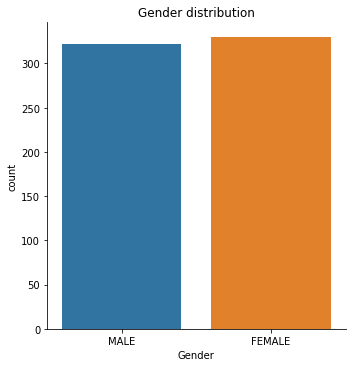

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


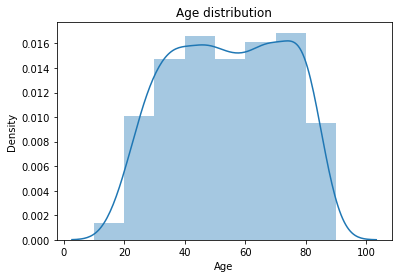

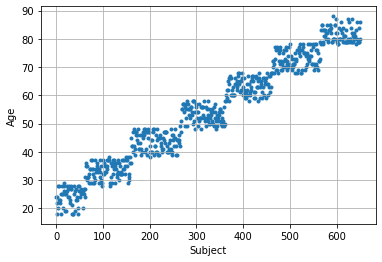

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

meta_data = meta_data_all

sns.catplot(x="gender_text", data=meta_data, kind="count")
plt.title('Gender distribution')
plt.xlabel('Gender')
plt.show()

sns.distplot(meta_data['age'], bins=[10,20,30,40,50,60,70,80,90])
plt.title('Age distribution')
plt.xlabel('Age')
plt.show()

plt.scatter(range(len(meta_data['age'])),meta_data['age'], marker='.')
plt.grid()
plt.xlabel('Subject')
plt.ylabel('Age')
plt.show()

### Set up a simple medical image viewer and import SimpleITK

In [5]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

# Calculate parameters low and high from window and level
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, x=None, y=None, z=None, window=None, level=None, colormap='gray', crosshair=False):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

    ax1.imshow(img_array[z,:,:], cmap=colormap, clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap=colormap, clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap=colormap, clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    if crosshair:
        ax1.axhline(y * spacing[1], lw=1)
        ax1.axvline(x * spacing[0], lw=1)
        ax2.axhline(z * spacing[2], lw=1)
        ax2.axvline(x * spacing[0], lw=1)
        ax3.axhline(z * spacing[2], lw=1)
        ax3.axvline(y * spacing[1], lw=1)

    plt.show()
    
def interactive_view(img):
    size = img.GetSize() 
    img_array = sitk.GetArrayFromImage(img)
    interact(display_image,img=fixed(img),
             x=(0, size[0] - 1),
             y=(0, size[1] - 1),
             z=(0, size[2] - 1),
             window=(0,np.max(img_array) - np.min(img_array)),
             level=(np.min(img_array),np.max(img_array)));

### Imaging data

Let's check out the imaging data that is available for each subject. This cell also shows how to retrieve data given a particular subject ID from the meta data.

Imaging data of subject CC110033 with age 24

MR Image


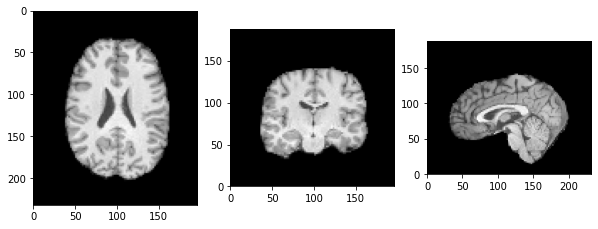

Brain mask


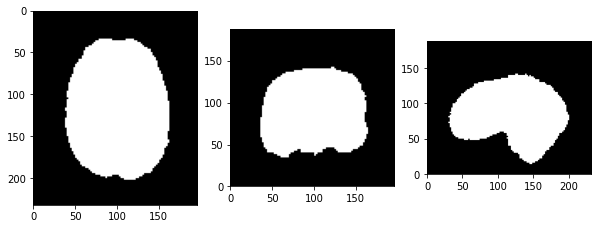

In [6]:
# Subject with index 0
ID = meta_data['subject_id'][0]
age = meta_data['age'][0]

# Image
image_filename = data_dir + 'images/sub-' + ID + '_T1w_unbiased.nii.gz'
img = sitk.ReadImage(image_filename)

# Mask
mask_filename = data_dir + 'masks/sub-' + ID + '_T1w_brain_mask.nii.gz'
msk = sitk.ReadImage(mask_filename)

print('Imaging data of subject ' + ID + ' with age ' + str(age))

print('\nMR Image')
display_image(img, window=400, level=200)

print('Brain mask')
display_image(msk)

## Part A: Age prediction using brain tissue segmentation and volume features

The first approach aims to regress the age of a subject using the volumes of brain tissues as features. The brain tissues include grey matter (GM), white matter (WM), and cerebrospinal fluid (CSF). It is known that with increasing age the ventricles enlarge (filled with CSF), while it is assumed that grey and white matter volume may decrease over time. However, as overall brain volume varies across individuals, taking the absolute volumes of tissues might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. To this end, a four-class (GM, WM, CSF, and background) brain segmentation needs to be implemented which will be trained using a total of 52 subjects (47 for training, 5 for validation). The segmentation method is then applied to the remaining 600 brain scans which will be used to train and test the age regression. Brain masks are provided which have been generated with a state-of-the-art neuroimaging brain extraction tool.

Different regression techniques should be explored, and it might be beneficial to investigate what the best set of features is for this task. Are all volume features equally useful, or is it even better to combine some of them and create new features. How does a simple linear regression perform compared to a model with higher order polynomials? Do you need regularisation? How about other regression methods such as regression trees, SVMs or neural networks? The accuracy of different methods should be evaluated using two-fold cross-validation on the set of 500 subjects, and average age prediction accuracy should be compared and reported appropriately. The final prediction accuracy will be evaluated on a hold-out set of 100 subjects.

*Note:* If you struggle with task A-1, you can continue with A-2 using the provided reference segmentations in subfolder `segs_refs`.

### TASK A-1: Brain tissue segmentation

Implement a CNN model for brain tissue segmentation which can provide segmentations of GM, WM, and CSF. For this task (and only for this task), we provide a subset of 52 subjects which are split into 47 images for training and 5 for validation. The template code below has the data handling and main training routines already implemented, so you can focus on implementing a suitable CNN model. A simple model is provided, but this won't perform very well.

Once your model is trained and you are happy with the results on the validation data you should apply it to the 500 subjects later used for training the age regressor. We provide reference segmentations in a subfolder `segs_refs` for all subjects. Calculate Dice similarity coefficients per tissue when comparing your predicted segmentations to the reference segmentations. Summarise the statistics of the 500 Dice scores for each tissue class in [box-and-whisker-plots](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.boxplot.html).

*Note:* Implementing a full-fledged machine learning pipeline with training and testing procedures in Jupyter notebooks is a bit cumbersome and a pain to debug. Also, running bigger training tasks can be unstable. The code below should work as is. However, if you want to get a bit more serious about implementing an advanced CNN approach for image segmentation, you may want to move code into separate Python scripts and run these from the terminal or an IDE such as [PyCharm](https://www.jetbrains.com/pycharm/).

#### Imports

In [13]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

#### Data Helpers

In [8]:
def zero_mean_unit_var(image, mask):
    """Normalizes an image to zero mean and unit variance."""

    img_array = sitk.GetArrayFromImage(image)
    img_array = img_array.astype(np.float32)

    msk_array = sitk.GetArrayFromImage(mask)

    mean = np.mean(img_array[msk_array>0])
    std = np.std(img_array[msk_array>0])

    if std > 0:
        img_array = (img_array - mean) / std
        img_array[msk_array==0] = 0

    image_normalised = sitk.GetImageFromArray(img_array)
    image_normalised.CopyInformation(image)

    return image_normalised


def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)


class ImageSegmentationDataset(Dataset):
    """Dataset for image segmentation."""

    def __init__(self, file_list_img, file_list_seg, file_list_msk, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        self.seg_names = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            seg_path = file_list_seg[idx]
            msk_path = file_list_msk[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)

            seg = sitk.ReadImage(seg_path, sitk.sitkInt64)

            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)

            #pre=processing
            img = zero_mean_unit_var(img, msk)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            seg = resample_image(seg, img_spacing, img_size, is_label=True)
            msk = resample_image(msk, img_spacing, img_size, is_label=True)

            sample = {'img': img, 'seg': seg, 'msk': msk}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))
            self.seg_names.append(os.path.basename(seg_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        seg = torch.from_numpy(sitk.GetArrayFromImage(sample['seg'])).unsqueeze(0)
        msk = torch.from_numpy(sitk.GetArrayFromImage(sample['msk'])).unsqueeze(0)

        return {'img': image, 'seg': seg, 'msk': msk}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_seg_name(self, item):
        return self.seg_names[item]


#### Check that the GPU is up and running

In [9]:
cuda_dev = '0' #GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))        

Device: cuda:0
GPU: NVIDIA RTX A4000


#### Config and hyper-parameters

Here we set some default hyper-parameters and a starting configuration for the image resolution and others.

**TASK: This needs to be revisited to optimise these values. In particular, you may want to run your final model on higher resolution images.**

In [27]:
rnd_seed = 42 #fixed random seed

img_size = [96, 96, 96]
img_spacing = [2, 2, 2]

num_epochs = 70
learning_rate = 0.001
batch_size = 4
val_interval = 10

num_classes = 4

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

#### Loading and pre-processing of training and validation data

In [13]:
meta_data_seg_train = pd.read_csv(data_dir + 'meta/meta_data_segmentation_train.csv')
ids_seg_train = list(meta_data_seg_train['subject_id'])
files_seg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_train]
files_seg_seg_train = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_train]
files_seg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_train]

meta_data_seg_val = pd.read_csv(data_dir + 'meta/meta_data_segmentation_val.csv')
ids_seg_val = list(meta_data_seg_val['subject_id'])
files_seg_img_val = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_val]
files_seg_seg_val = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_val]
files_seg_msk_val = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_val]

We apply some standard pre-processing on the data such as intensity normalization (zero mean unit variance) and downsampling according to the configuration above.

**You may want to use initially the validation data with 5 subjects for training which is more efficient when debugging your training routine and model implementation. Make sure to later train your final model on the actual training data.**

In [136]:
# LOAD TRAINING DATA
dataset_train = ImageSegmentationDataset(files_seg_img_train, files_seg_seg_train, files_seg_msk_train, img_spacing, img_size)
# FOR QUICK DEBUGGING, USE THE VALIDATION DATA FOR TRAINING
#dataset_train = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# LOAD VALIDATION DATA
dataset_val = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 5/5 [00:00<00:00,  7.91it/s]


#### Visualise training example

Just to check how a training image looks like after pre-processing.

Image: sub-CC221040_T1w_unbiased.nii.gz


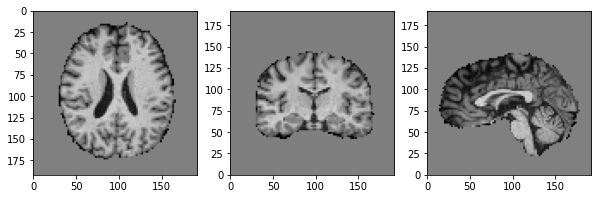

Segmentation


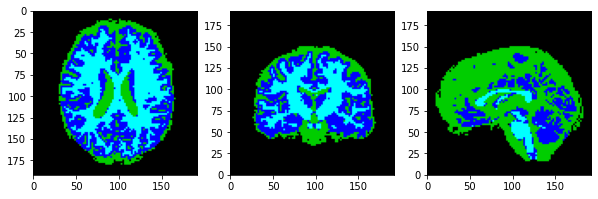

Mask


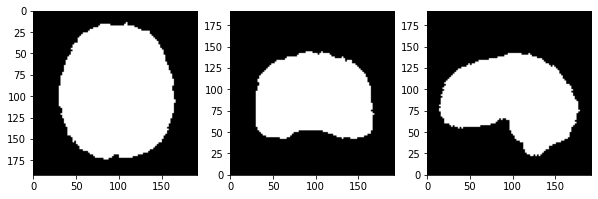

In [137]:
sample = dataset_train.get_sample(0)
img_name = dataset_train.get_img_name(0)
seg_name = dataset_train.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### The Model

**TASK:** This is the **key part of task A-1** where you have to design a suitable CNN model for brain segmentation. The simple model provided below works to some degree (it let's you run through the upcoming cells), but it will not perform very well. Use what you learned in the lectures to come up with a good architecture. Start with a simple, shallow model and only increase complexity (e.g., number of layers) if needed.

In [14]:
class DoubleConvolution(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConvolution, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        
        return self.double_conv(x)
    
class CustomUNet(nn.Module):

    def __init__(self, num_classes):
        super(CustomUNet, self).__init__()
        #Encoder 
        self.cov1 = DoubleConvolution(1, 16)
        self.dconv1 = nn.Sequential(
            nn.MaxPool3d(kernel_size=2, stride=2),
            DoubleConvolution(16, 32)
        )
        self.dconv2 = nn.Sequential(
            nn.MaxPool3d(kernel_size=2, stride=2),
            DoubleConvolution(32, 64)
        )
        self.dconv3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=2, stride=2),
            DoubleConvolution(64, 128)
        )
        self.dconv4 = nn.Sequential(
            nn.MaxPool3d(kernel_size=2, stride=2),
            DoubleConvolution(128, 256)
        )
        #Decoder
        self.up1 = nn.Sequential(
            nn.ConvTranspose3d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(128)
        )
        self.upconv1 = DoubleConvolution(256, 128)
        
        self.up2 = nn.Sequential(
            nn.ConvTranspose3d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(64)
        )
        self.upconv2 = DoubleConvolution(128, 64)
        
        self.up3 = nn.ConvTranspose3d(64, 32, kernel_size=4, stride=2, padding=1)
        self.upconv3 = nn.Sequential(
            DoubleConvolution(64, 32),
            nn.BatchNorm3d(32)
        )
    
        self.up4 = nn.ConvTranspose3d(32, 16, kernel_size=2, stride=2)
        self.upconv4 = nn.Sequential(
            DoubleConvolution(32, 16),
            nn.BatchNorm3d(16)
        )
        
        self.out = nn.Conv3d(16, num_classes, kernel_size=1)
        
    def forward(self, x):
        #Encoder 
        x1 = self.cov1(x)
        x2 = self.dconv1(x1)
        x3 = self.dconv2(x2)
        x4 = self.dconv3(x3)
        x = self.dconv4(x4)
        #Decoder 
        x = self.up1(x)
        x = self.upconv1(torch.cat([x4,x], 1))
        x = self.up2(x)
        x = self.upconv2(torch.cat([x3,x], 1))
        x = self.up3(x)
        x = self.upconv3(torch.cat([x2,x], 1))
        x = self.up4(x)
        x = self.upconv4(torch.cat([x1,x], 1))        
        x = self.out(x)   
        
        return x # cross-entropy loss expects raw logits and applies softmax

#### TRAINING


Below is an implementation of a full training procedure including a loop for intermediate evaluation of the model on the validation data. Feel free to modify this procedure. For example, in addition to the loss you may want to monitor Dice scores (or others).

In [139]:
from sklearn.metrics import confusion_matrix

def dice_coefficient(y_true, y_pred, num_classes=4):
    """
    Dice Similarity Coefficient
    """
    eps = 1e-6
    dice_scores = torch.zeros(num_classes)
    for i in range(num_classes):
        y_true_i = (y_true == i).float()
        y_pred_i = (y_pred == i).float()
        intersection = torch.sum(y_true_i * y_pred_i)
        union = torch.sum(y_true_i) + torch.sum(y_pred_i)
        dice_scores[i] = (2. * intersection + eps) / (union + eps)
    mean_dice_score = torch.mean(dice_scores)
    return dice_scores, mean_dice_score

def f1_score_per_class(y_true, y_pred, num_classes=4):
    """
    F-1 score per class in a one-vs-rest manner
    """
    if num_classes is None:
        num_classes = torch.max(y_true) + 1

    per_class_f1 = torch.zeros(num_classes)
    per_class_precision = torch.zeros(num_classes)
    per_class_recall = torch.zeros(num_classes)
    
    for i in range(num_classes):
        y_true_i = (y_true == i).float()
        y_pred_i = (y_pred == i).float()

        tp = torch.sum(y_true_i * y_pred_i)
        fp = torch.sum((1 - y_true_i) * y_pred_i)
        fn = torch.sum(y_true_i * (1 - y_pred_i))

        precision = tp / (tp + fp + 1e-6)
        recall = tp / (tp + fn + 1e-6)

        per_class_f1[i] = 2 * precision * recall / (precision + recall + 1e-6)
        per_class_precision[i] = precision
        per_class_recall[i] = recall
    
    return per_class_f1, per_class_precision, per_class_recall


def plot_heat_map(y_true, y_pred):
    # create the confusion matrix
    y_true = y_true.cpu().numpy().flatten()
    y_pred = y_pred.cpu().numpy().flatten()
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    # plot the confusion matrix
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True, fmt='.3%', cmap='Blues', cbar=False, 
                xticklabels = ['Background', 'CSF', 'GM', 'WM'],
                yticklabels = ['Background', 'CSF', 'GM', 'WM'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion matrix')

    plt.show()

""" Example usage:
inputs = next(iter(dataloader_train))   
x = inputs["seg"].to(device)
dice_coefficient(x, x, 4), f1_score_per_class(x, x, 4)
plot_heat_map(x, x)
"""

' Example usage:\ninputs = next(iter(dataloader_train))   \nx = inputs["seg"].to(device)\ndice_coefficient(x, x, 4), f1_score_per_class(x, x, 4)\nplot_heat_map(x, x)\n'

START TRAINING...
+ TRAINING 	Epoch: 1 	Loss: 0.547850
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 0.547565
Dice Score per Class: 
 Background:0.9824814796447754, CSF: 0.581473708152771, GM:0.478318452835083, WM:0.7472662925720215
Mean Dice Score: 0.6973850131034851
F1-Score per Class: 
 Background:0.9824810028076172, CSF: 0.5814732313156128, GM:0.4783179759979248, WM:0.7472658157348633
Precision per Class: 
 Background:0.991467297077179, CSF: 0.5344933867454529, GM:0.5676679611206055, WM:0.6327191591262817
Recall per Class: 
 Background:0.9737532734870911, CSF: 0.6489418148994446, GM:0.41337481141090393, WM:0.9148555994033813
Macro-averaged scores:
 F1-Score:0.6973844766616821, Precision:0.6815869808197021, Recall:0.7377313375473022


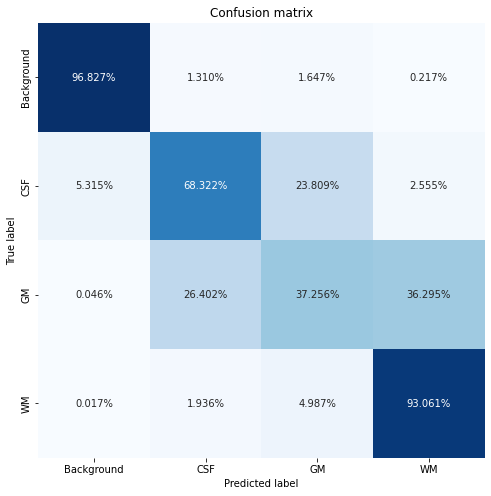

Prediction


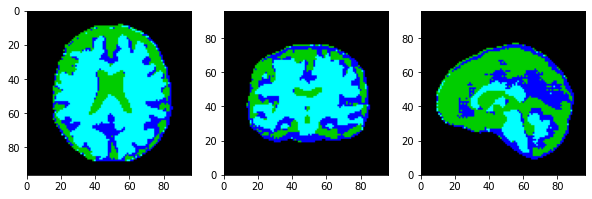

Target


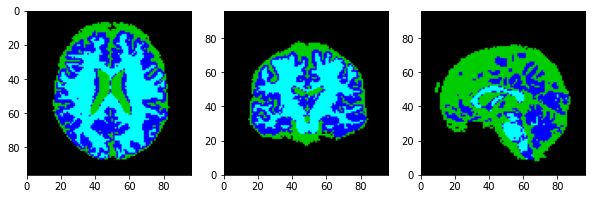

--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 0.451503
+ TRAINING 	Epoch: 3 	Loss: 0.411025
+ TRAINING 	Epoch: 4 	Loss: 0.340030
+ TRAINING 	Epoch: 5 	Loss: 0.299560
+ TRAINING 	Epoch: 6 	Loss: 0.258608
+ TRAINING 	Epoch: 7 	Loss: 0.240707
+ TRAINING 	Epoch: 8 	Loss: 0.211312
+ TRAINING 	Epoch: 9 	Loss: 0.194123
+ TRAINING 	Epoch: 10 	Loss: 0.193491
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 0.188542
Dice Score per Class: 
 Background:0.9893285036087036, CSF: 0.7639626860618591, GM:0.838170051574707, WM:0.8741458058357239
Mean Dice Score: 0.8664017915725708
F1-Score per Class: 
 Background:0.9893280267715454, CSF: 0.7639622092247009, GM:0.8381695747375488, WM:0.8741453289985657
Precision per Class: 
 Background:0.989721417427063, CSF: 0.7159690260887146, GM:0.8567444682121277, WM:0.9025636911392212
Recall per Class: 
 Background:0.9890269041061401, CSF: 0.8310624957084656, GM:0.8206466436386108, WM:0.8483313322067261

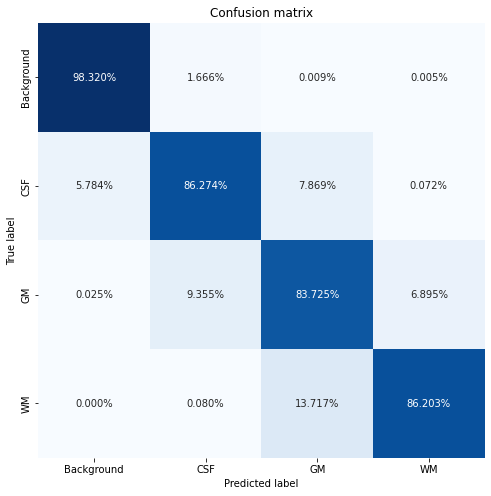

Prediction


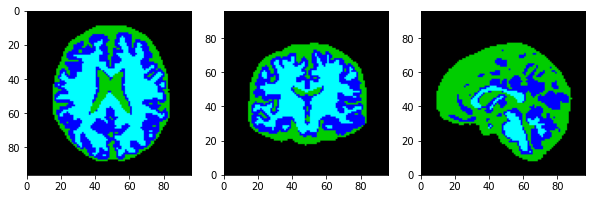

Target


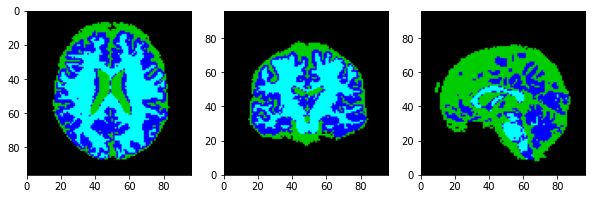

--------------------------------------------------
+ TRAINING 	Epoch: 11 	Loss: 0.166550
+ TRAINING 	Epoch: 12 	Loss: 0.186059
+ TRAINING 	Epoch: 13 	Loss: 0.144535
+ TRAINING 	Epoch: 14 	Loss: 0.144021
+ TRAINING 	Epoch: 15 	Loss: 0.126654
+ TRAINING 	Epoch: 16 	Loss: 0.149834
+ TRAINING 	Epoch: 17 	Loss: 0.124319
+ TRAINING 	Epoch: 18 	Loss: 0.114298
+ TRAINING 	Epoch: 19 	Loss: 0.118810
+ TRAINING 	Epoch: 20 	Loss: 0.098188
--------------------------------------------------
+ VALIDATE 	Epoch: 20 	Loss: 0.108127
Dice Score per Class: 
 Background:0.99024498462677, CSF: 0.7805848121643066, GM:0.9053667187690735, WM:0.9350182414054871
Mean Dice Score: 0.9028037190437317
F1-Score per Class: 
 Background:0.9902445077896118, CSF: 0.7805843353271484, GM:0.9053662419319153, WM:0.9350177645683289
Precision per Class: 
 Background:0.9859167337417603, CSF: 0.8624264001846313, GM:0.8776040077209473, WM:0.9457929730415344
Recall per Class: 
 Background:0.9946915507316589, CSF: 0.7202034592628479

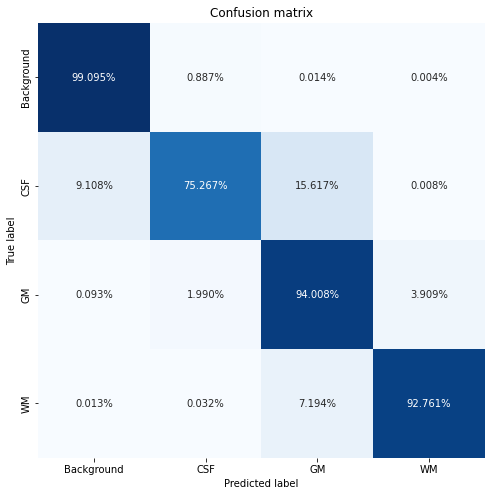

Prediction


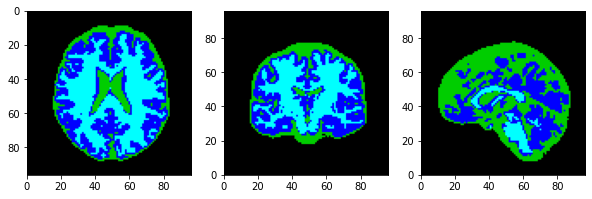

Target


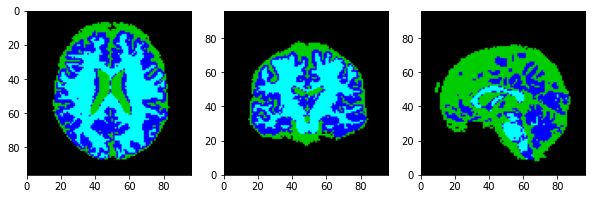

--------------------------------------------------
+ TRAINING 	Epoch: 21 	Loss: 0.107370
+ TRAINING 	Epoch: 22 	Loss: 0.097502
+ TRAINING 	Epoch: 23 	Loss: 0.104379
+ TRAINING 	Epoch: 24 	Loss: 0.095144
+ TRAINING 	Epoch: 25 	Loss: 0.102375
+ TRAINING 	Epoch: 26 	Loss: 0.083638
+ TRAINING 	Epoch: 27 	Loss: 0.089669
+ TRAINING 	Epoch: 28 	Loss: 0.084898
+ TRAINING 	Epoch: 29 	Loss: 0.097366
+ TRAINING 	Epoch: 30 	Loss: 0.077022
--------------------------------------------------
+ VALIDATE 	Epoch: 30 	Loss: 0.084152
Dice Score per Class: 
 Background:0.9904530644416809, CSF: 0.824886679649353, GM:0.9249773025512695, WM:0.9475374221801758
Mean Dice Score: 0.9219635725021362
F1-Score per Class: 
 Background:0.9904525876045227, CSF: 0.8248862028121948, GM:0.9249768257141113, WM:0.9475369453430176
Precision per Class: 
 Background:0.9907281994819641, CSF: 0.8102264404296875, GM:0.9373067617416382, WM:0.9381983876228333
Recall per Class: 
 Background:0.9902553558349609, CSF: 0.850047945976257

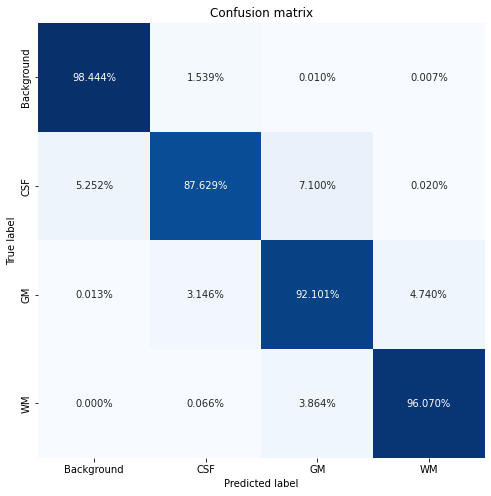

Prediction


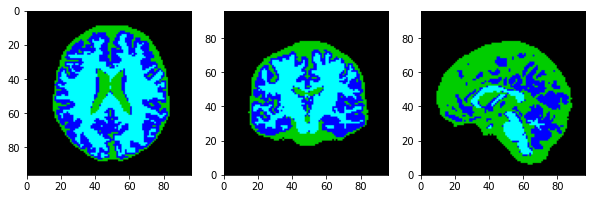

Target


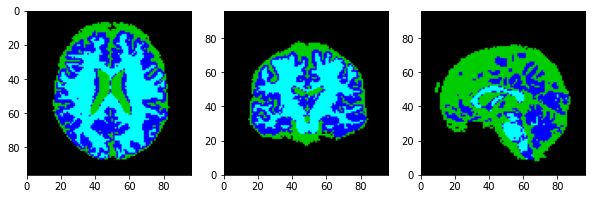

--------------------------------------------------
+ TRAINING 	Epoch: 31 	Loss: 0.092131
+ TRAINING 	Epoch: 32 	Loss: 0.080665
+ TRAINING 	Epoch: 33 	Loss: 0.066597
+ TRAINING 	Epoch: 34 	Loss: 0.093244
+ TRAINING 	Epoch: 35 	Loss: 0.069946
+ TRAINING 	Epoch: 36 	Loss: 0.077412
+ TRAINING 	Epoch: 37 	Loss: 0.066360
+ TRAINING 	Epoch: 38 	Loss: 0.072206
+ TRAINING 	Epoch: 39 	Loss: 0.080783
+ TRAINING 	Epoch: 40 	Loss: 0.094686
--------------------------------------------------
+ VALIDATE 	Epoch: 40 	Loss: 0.083675
Dice Score per Class: 
 Background:0.9902321100234985, CSF: 0.811182975769043, GM:0.9125708341598511, WM:0.9503625631332397
Mean Dice Score: 0.9160870313644409
F1-Score per Class: 
 Background:0.9902315139770508, CSF: 0.8111824989318848, GM:0.9125703573226929, WM:0.9503620862960815
Precision per Class: 
 Background:0.9913082122802734, CSF: 0.7550126314163208, GM:0.940991222858429, WM:0.9681583642959595
Recall per Class: 
 Background:0.9892297983169556, CSF: 0.8873227834701538

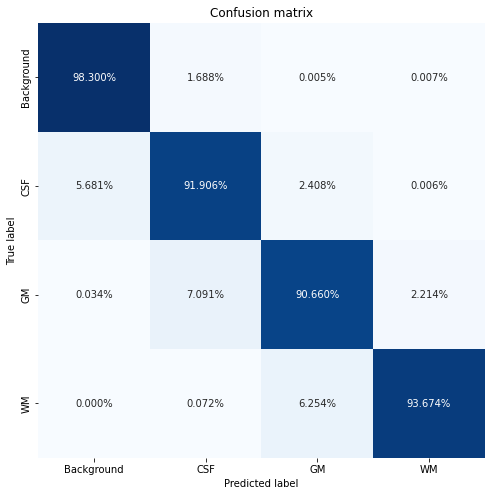

Prediction


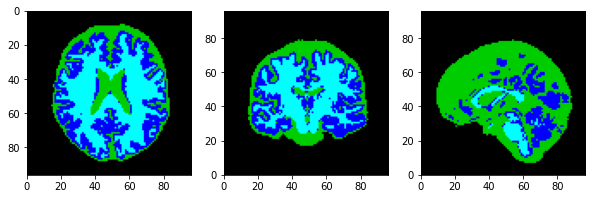

Target


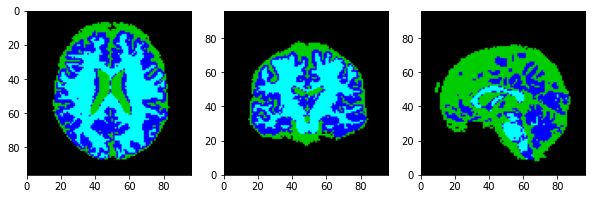

--------------------------------------------------
+ TRAINING 	Epoch: 41 	Loss: 0.076308
+ TRAINING 	Epoch: 42 	Loss: 0.075771
+ TRAINING 	Epoch: 43 	Loss: 0.067512
+ TRAINING 	Epoch: 44 	Loss: 0.069687
+ TRAINING 	Epoch: 45 	Loss: 0.071684
+ TRAINING 	Epoch: 46 	Loss: 0.080901
+ TRAINING 	Epoch: 47 	Loss: 0.075943
+ TRAINING 	Epoch: 48 	Loss: 0.069307
+ TRAINING 	Epoch: 49 	Loss: 0.061004
+ TRAINING 	Epoch: 50 	Loss: 0.060994
--------------------------------------------------
+ VALIDATE 	Epoch: 50 	Loss: 0.069480
Dice Score per Class: 
 Background:0.9909788370132446, CSF: 0.831717848777771, GM:0.9361375570297241, WM:0.9537177085876465
Mean Dice Score: 0.9281380772590637
F1-Score per Class: 
 Background:0.9909783601760864, CSF: 0.8317174911499023, GM:0.9361370801925659, WM:0.9537172317504883
Precision per Class: 
 Background:0.9869246482849121, CSF: 0.8660801649093628, GM:0.9271360635757446, WM:0.9750210046768188
Recall per Class: 
 Background:0.9951399564743042, CSF: 0.808031380176544

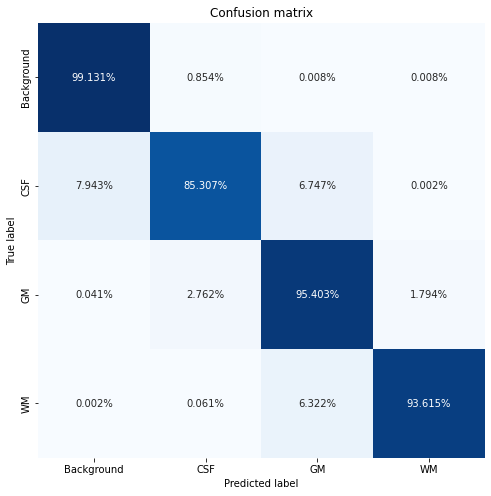

Prediction


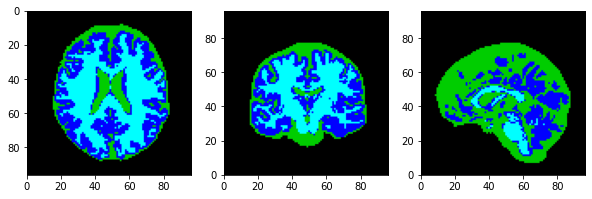

Target


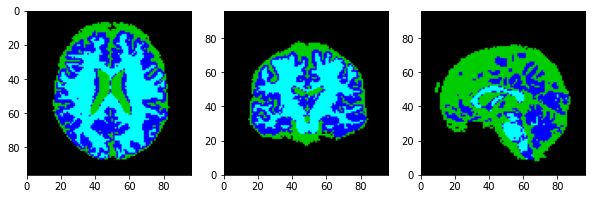

--------------------------------------------------
+ TRAINING 	Epoch: 51 	Loss: 0.093467
+ TRAINING 	Epoch: 52 	Loss: 0.072097
+ TRAINING 	Epoch: 53 	Loss: 0.076945
+ TRAINING 	Epoch: 54 	Loss: 0.062260
+ TRAINING 	Epoch: 55 	Loss: 0.064438
+ TRAINING 	Epoch: 56 	Loss: 0.068139
+ TRAINING 	Epoch: 57 	Loss: 0.057600
+ TRAINING 	Epoch: 58 	Loss: 0.069273
+ TRAINING 	Epoch: 59 	Loss: 0.055770
+ TRAINING 	Epoch: 60 	Loss: 0.061607
--------------------------------------------------
+ VALIDATE 	Epoch: 60 	Loss: 0.067638
Dice Score per Class: 
 Background:0.9912616014480591, CSF: 0.8378597497940063, GM:0.931815505027771, WM:0.9529638290405273
Mean Dice Score: 0.9284752011299133
F1-Score per Class: 
 Background:0.9912611246109009, CSF: 0.8378591537475586, GM:0.9318150281906128, WM:0.9529632329940796
Precision per Class: 
 Background:0.9908315539360046, CSF: 0.8369244337081909, GM:0.9464410543441772, WM:0.9327021837234497
Recall per Class: 
 Background:0.99176025390625, CSF: 0.8474311828613281,

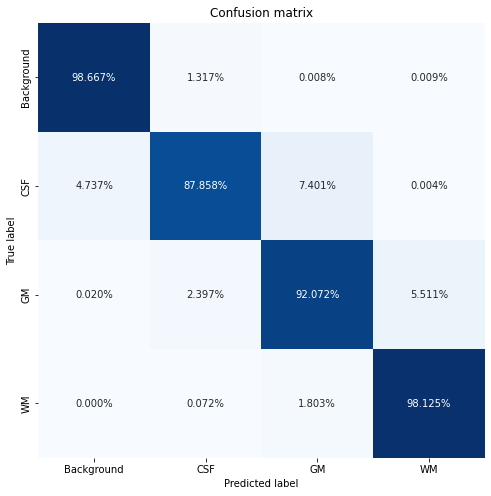

Prediction


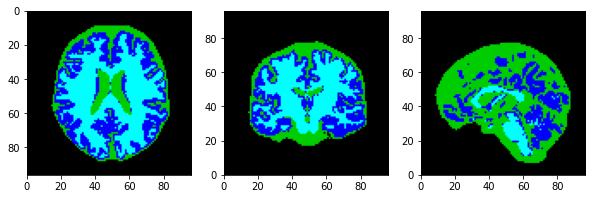

Target


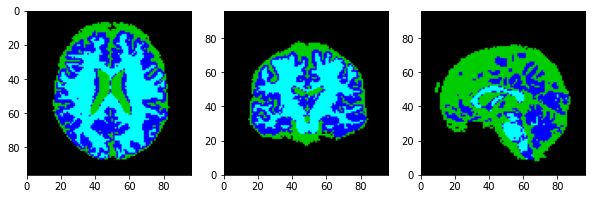

--------------------------------------------------
+ TRAINING 	Epoch: 61 	Loss: 0.061595
+ TRAINING 	Epoch: 62 	Loss: 0.061043
+ TRAINING 	Epoch: 63 	Loss: 0.059553
+ TRAINING 	Epoch: 64 	Loss: 0.068028
+ TRAINING 	Epoch: 65 	Loss: 0.080881
+ TRAINING 	Epoch: 66 	Loss: 0.053340
+ TRAINING 	Epoch: 67 	Loss: 0.059302
+ TRAINING 	Epoch: 68 	Loss: 0.059922
+ TRAINING 	Epoch: 69 	Loss: 0.049852
+ TRAINING 	Epoch: 70 	Loss: 0.056544
--------------------------------------------------
+ VALIDATE 	Epoch: 70 	Loss: 0.062801
Dice Score per Class: 
 Background:0.9913445711135864, CSF: 0.8451967239379883, GM:0.9403416514396667, WM:0.9586948156356812
Mean Dice Score: 0.9338944554328918
F1-Score per Class: 
 Background:0.9913440942764282, CSF: 0.8451962471008301, GM:0.9403411746025085, WM:0.9586944580078125
Precision per Class: 
 Background:0.9910418391227722, CSF: 0.833742618560791, GM:0.9422386884689331, WM:0.9678447842597961
Recall per Class: 
 Background:0.9917090535163879, CSF: 0.865740478038787

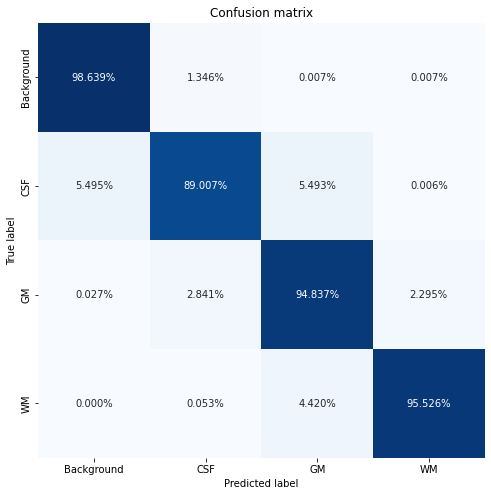

Prediction


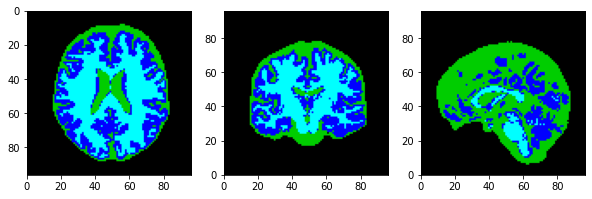

Target


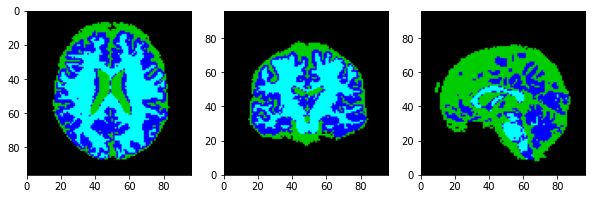

--------------------------------------------------

Finished TRAINING.


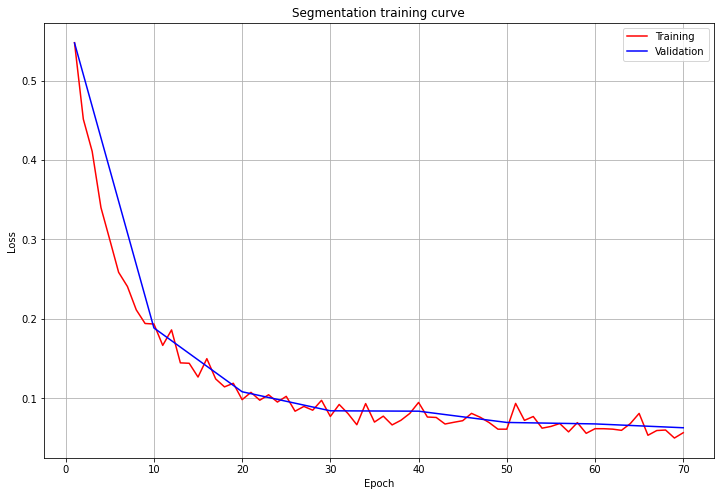

In [140]:
model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.manual_seed(rnd_seed) #fix random seed

model = CustomUNet(num_classes=num_classes).to(device)
model.train()
    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_train_log = []
loss_val_log = []
epoch_val_log = []
    
print('START TRAINING...')
for epoch in range(1, num_epochs + 1):

    # Training
    batch_mean_dice = 0
    batch_dice_scores = torch.zeros(4)
    
    for batch_idx, batch_samples in enumerate(dataloader_train):
        img, seg = batch_samples['img'].to(device), batch_samples['seg'].to(device)
        optimizer.zero_grad()
        prd = model(img)
        loss = F.cross_entropy(prd, seg.squeeze(1))
        loss.backward()
        optimizer.step()        

    loss_train_log.append(loss.item())
    
    dice_scores = batch_dice_scores/len(dataloader_train)
    mean_dice_score = batch_mean_dice/len(dataloader_train)
    
    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

    # Validation
    batch_mean_dice = 0
    batch_dice_scores = torch.zeros(4)
    batch_f1_score = torch.zeros(4)
    batch_precision = torch.zeros(4)
    batch_recall = torch.zeros(4)
    
    if epoch == 1 or epoch % val_interval == 0:
        loss_val = 0
        sum_pts = 0
        with torch.no_grad():
            for data_sample in dataloader_val:
                img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
                prd = model(img)
                loss_val += F.cross_entropy(prd, seg.squeeze(1), reduction='sum').item()
                sum_pts += np.prod(img_size)
                
                f1_score, precision, recall = f1_score_per_class(seg, torch.argmax(prd, dim=1), 4)
                dice_scores, mean_dice_score = dice_coefficient(seg, torch.argmax(prd, dim=1), 4)
                batch_dice_scores += (dice_scores/1)
                batch_mean_dice += (mean_dice_score/1)
                batch_f1_score += f1_score
                batch_precision += precision
                batch_recall += recall
                
        prd = torch.argmax(prd, dim=1)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        real = sitk.GetImageFromArray(seg.cpu().squeeze().numpy().astype(np.uint8))
        
        loss_val /= sum_pts

        loss_val_log.append(loss_val)
        epoch_val_log.append(epoch)
        
        batch_dice_scores /= len(dataloader_val)
        batch_mean_dice /= len(dataloader_val)
        batch_f1_score /= len(dataloader_val)
        batch_precision /= len(dataloader_val)
        batch_recall /= len(dataloader_val)
                
        print('--------------------------------------------------')
        print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss_val))
        print(f'Dice Score per Class: \n Background:{batch_dice_scores[0]}, CSF: {batch_dice_scores[1]}, GM:{batch_dice_scores[2]}, WM:{batch_dice_scores[3]}')
        print(f'Mean Dice Score: {batch_mean_dice}')
        print(f'F1-Score per Class: \n Background:{batch_f1_score[0]}, CSF: {batch_f1_score[1]}, GM:{batch_f1_score[2]}, WM:{batch_f1_score[3]}')
        print(f'Precision per Class: \n Background:{batch_precision[0]}, CSF: {batch_precision[1]}, GM:{batch_precision[2]}, WM:{batch_precision[3]}')
        print(f'Recall per Class: \n Background:{batch_recall[0]}, CSF: {batch_recall[1]}, GM:{batch_recall[2]}, WM:{batch_recall[3]}')
        print(f'Macro-averaged scores:\n F1-Score:{torch.mean(batch_f1_score)}, Precision:{torch.mean(batch_precision)}, Recall:{torch.mean(batch_recall)}')
        
        plot_heat_map(seg, prd)
        
        print("Prediction")
        display_image(sitk.LabelToRGB(prediction))
        print("Target")
        display_image(sitk.LabelToRGB(real))
        
        print('--------------------------------------------------')

torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))

print('\nFinished TRAINING.')

plt.figure(figsize=(12,8))
plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='Training')
plt.plot(epoch_val_log, loss_val_log, c='b', label='Validation')
plt.legend(loc='upper right')
plt.title("Segmentation training curve")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

#### Loading and pre-processing of testing data

Now that we have trained a model, the next cells are about applying that model to the 500 subjects that are used for training the age regressor. Note, at a later stage you will also need to run the model on the 100 subjects from the hold-out set, once these have been made available. Before testing on the full set, you may want to initially just test on the 5 validation subjects to check everything is working fine.

In [141]:
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_seg_test = list(meta_data_reg_train['subject_id'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 500/500 [00:56<00:00,  8.79it/s]


#### Visualise testing example

Just to check how a testing image looks like after pre-processing.

Image: sub-CC520745_T1w_unbiased.nii.gz


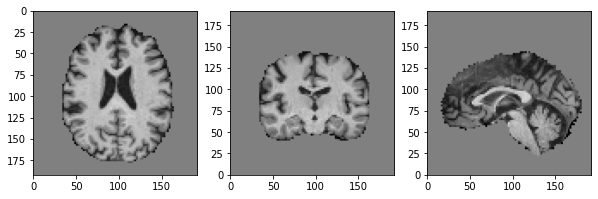

Segmentation


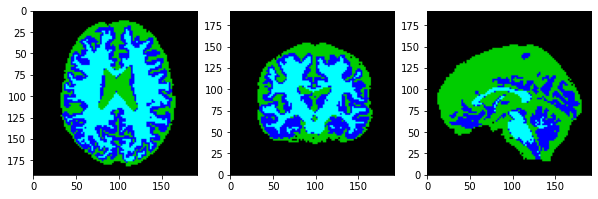

Mask


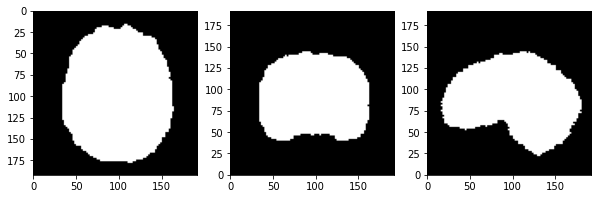

In [142]:
sample = dataset_test.get_sample(0)
img_name = dataset_test.get_img_name(0)
seg_name = dataset_test.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### TESTING

Below is an implementation of a full testing procedure that saves the segmentations in an output folder. Feel free to modify this procedure.

**TASK: You will need to add the calculations of Dice scores (and possibly other metrics) to evaluate the segmentation performance.**

In [143]:
def plot_dice_scores(all_dice_scores):
    # create example datasets
    data1 = all_dice_scores[:,0].numpy()
    data2 = all_dice_scores[:,1].numpy()
    data3 = all_dice_scores[:,2].numpy()
    data4 = all_dice_scores[:,3].numpy()

    # create a list of the datasets
    data_list = [data1, data2, data3, data4]

    # create a box plot with all the datasets
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.boxplot(data_list)

    # add x-axis labels to each box plot
    ax.set_xticklabels(['Background', 'CSF', 'GM', 'WM'])

    # add a y-axis label and a title to the plot
    ax.set_xlabel('Class Label')
    ax.set_ylabel('Dice Score')
    ax.set_title('Dice scores for each tissue class')

    # show the plot
    plt.show()

START TESTING...
+ TESTING 	Loss: 0.067269
Dice Score per Class: 
 Background:0.9919829368591309, CSF: 0.8476362824440002, GM:0.925864577293396, WM:0.9514211416244507
Mean Dice Score: 0.9292262835502625
F1-Score per Class: 
 Background:0.9919825792312622, CSF: 0.8476359844207764, GM:0.9258642196655273, WM:0.951420783996582
Precision per Class: 
 Background:0.9898629784584045, CSF: 0.880262017250061, GM:0.9257922768592834, WM:0.9404574632644653
Recall per Class: 
 Background:0.9941502809524536, CSF: 0.8228862881660461, GM:0.9274771809577942, WM:0.9641191959381104
Macro-averaged scores:
 F1-Score:0.9292259216308594, Precision:0.934093713760376, Recall:0.9271582365036011


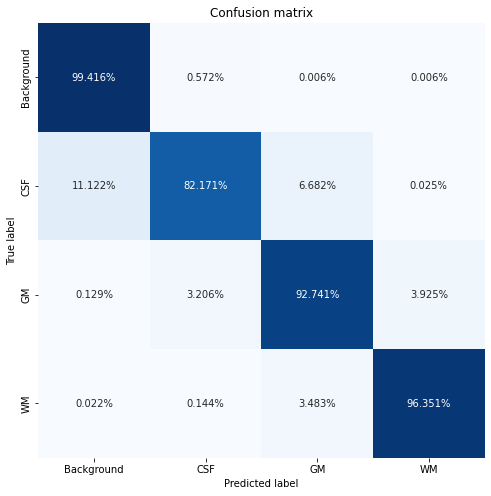

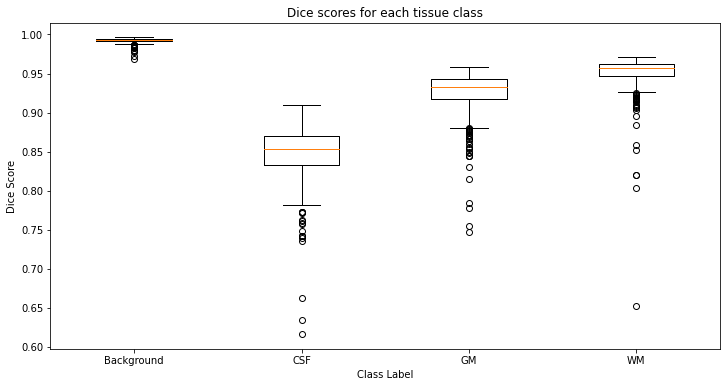



Reference segmentation


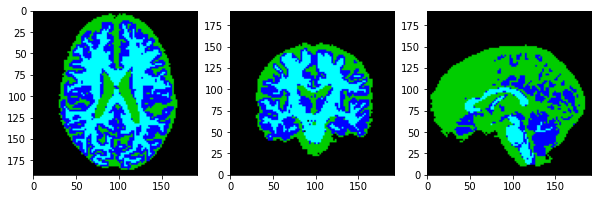

Predicted segmentation


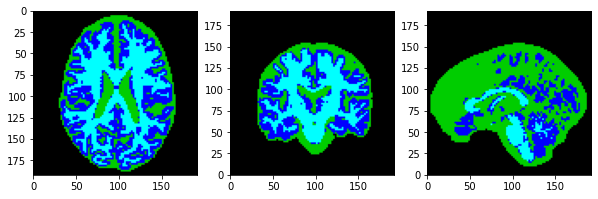


Finished TESTING.


In [144]:
pred_dir = os.path.join(out_dir, 'pred')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

model = CustomUNet(num_classes=num_classes)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
model.to(device)
model.eval()
    
print('START TESTING...')

loss_test = 0
sum_pts = 0
idx_test = 0

batch_mean_dice = 0
batch_dice_scores = torch.zeros(4)
all_dice_scores = torch.empty(len(dataloader_test), 4)
batch_f1_score = torch.zeros(4)
batch_precision = torch.zeros(4)
batch_recall = torch.zeros(4)

all_pred = torch.empty(len(dataloader_test), 96, 96, 96)
all_seg = torch.empty(len(dataloader_test), 96, 96, 96)
    
with torch.no_grad():
    for data_sample in dataloader_test:
        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        prd = model(img)
        loss_test += F.cross_entropy(prd, seg.squeeze(1), reduction='sum').item()
        sum_pts += np.prod(img_size)
        
        prd = torch.argmax(prd, dim=1)
        
        f1_score, precision, recall = f1_score_per_class(seg, prd, 4)
        dice_scores, m_dice_score = dice_coefficient(seg, prd, 4)
        batch_dice_scores += dice_scores
        all_dice_scores[idx_test, :] = dice_scores
        batch_mean_dice += m_dice_score.item()
        batch_f1_score += f1_score
        batch_precision += precision
        batch_recall += recall
        
        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        prediction.CopyInformation(sample['seg'])
        sitk.WriteImage(prediction, os.path.join(pred_dir, name))
        
        all_pred[idx_test, :, :, :] = prd
        all_seg[idx_test, :, :, :] = seg
        
        idx_test += 1
        
loss_test /= sum_pts
batch_mean_dice /= len(dataloader_test)
batch_dice_scores /= len(dataloader_test)
batch_f1_score /= len(dataloader_test)
batch_precision /= len(dataloader_test)
batch_recall /= len(dataloader_test)

print('+ TESTING \tLoss: {:.6f}'.format(loss_test))
print(f'Dice Score per Class: \n Background:{batch_dice_scores[0]}, CSF: {batch_dice_scores[1]}, GM:{batch_dice_scores[2]}, WM:{batch_dice_scores[3]}')
print(f'Mean Dice Score: {batch_mean_dice}')
print(f'F1-Score per Class: \n Background:{batch_f1_score[0]}, CSF: {batch_f1_score[1]}, GM:{batch_f1_score[2]}, WM:{batch_f1_score[3]}')
print(f'Precision per Class: \n Background:{batch_precision[0]}, CSF: {batch_precision[1]}, GM:{batch_precision[2]}, WM:{batch_precision[3]}')
print(f'Recall per Class: \n Background:{batch_recall[0]}, CSF: {batch_recall[1]}, GM:{batch_recall[2]}, WM:{batch_recall[3]}')
print(f'Macro-averaged scores:\n F1-Score:{torch.mean(batch_f1_score)}, Precision:{torch.mean(batch_precision)}, Recall:{torch.mean(batch_recall)}')

plot_heat_map(all_seg, all_pred)

plot_dice_scores(all_dice_scores)

# Show last testing sample as an example
print('\n\nReference segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Predicted segmentation')
display_image(sitk.LabelToRGB(prediction))

print('\nFinished TESTING.')

### TASK A-2: Feature calculation

Start by calculating the three absolute tissue volumes for each subject. Plot the volumes against the subjects' ages. Taking the absolute volumes of tissues as features, however, might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. But you might also want to explore using different combinations or even polynomial features.

Implement a function that constructs a big matrix $X$ with a row for each subject and features across the columns. Start with just calculating three simple features of relative tissue volumes for GM, WM and CSF, and compare these to the absolute volumes plotted above.

*Note:* If you are struggling with the previous task on image segmentation, or if you prefer to work on this and the following tasks first, you can continue here using the provided reference segmentations which can be found in a subfolder `segs_refs`.

In [15]:
## CALCULATE ABSOLUTE TISSUE VOLUMES

import os

# USE THIS TO RUN THE CALCULATIONS ON YOUR SEGMENTATONS
seg_dir = './output/pred/'

# USE THIS TO RUN THE CALCULATIONS ON OUR REFERENCE SEGMENTATIONS
#seg_dir = data_dir + 'segs_refs/'

meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_reg_train = list(meta_data_reg_train['subject_id'])
files_reg_seg_train = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_train]

# THIS MATRIX WILL STORE THE VOLUMES PER TISSUE CLASS
vols = np.zeros((3,len(files_reg_seg_train)))
"""
1: CSF, 2: GM, 3: WM
"""
for idx, _ in enumerate(tqdm(range(len(files_reg_seg_train)), desc='Calculating Features')):
    
    seg_filename = files_reg_seg_train[idx]
    
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)
        seg = torch.from_numpy(sitk.GetArrayFromImage(seg)).unsqueeze(0)
        for i in range(1, 4):
            count_total = (seg == i).sum()
            vols[i-1, idx] = count_total

Calculating Features: 100%|██████████| 500/500 [00:06<00:00, 72.65it/s] 


Plot features versus age.

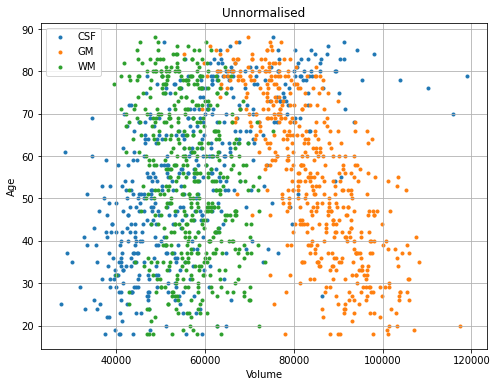

In [16]:
plt.figure(figsize=(8,6))
plt.scatter(vols[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols[2,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Unnormalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

In [17]:
## CALCULATE RELATIVE TISSUE VOLUMES
vols_normalised = np.zeros((3,len(files_reg_seg_train)))
vols_normalised = vols/vols.sum(axis=0)


Plot normalised features versus age.

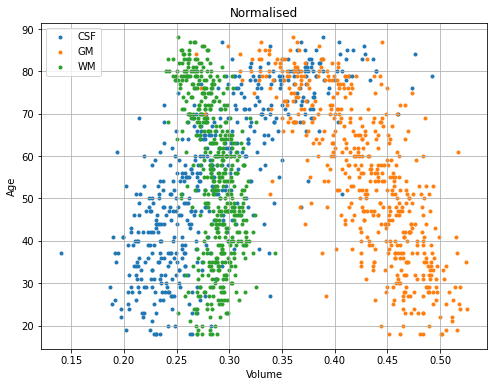

In [18]:
plt.figure(figsize=(8,6))
plt.scatter(vols_normalised[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised[2,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Normalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

Exploring new features for linear regression

In [19]:
X = vols_normalised.T

# Creating new features 
square_X = X**2
log_X = np.log(X)

ratio_CSF_to_GM = X[:,0]/X[:,1]
ratio_CSF_to_WM = X[:,0]/X[:,2]
ratio_GM_to_CSF = X[:,1]/X[:,0]
ratio_GM_to_WM  = X[:,1]/X[:,2]
ratio_WM_to_GM  = X[:,2]/X[:,1]
ratio_WM_to_CSF = X[:,2]/X[:,0] 

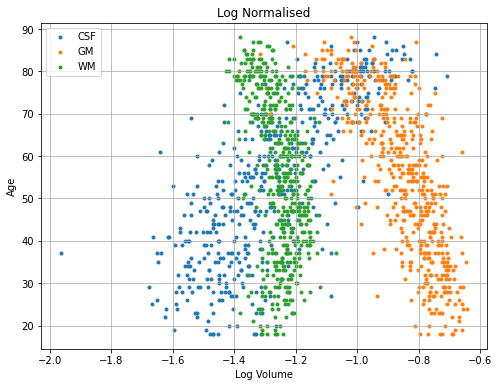

In [20]:
plt.figure(figsize=(8,6))

plt.scatter(log_X.T[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(log_X.T[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(log_X.T[2,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Log Normalised')
plt.xlabel('Log Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

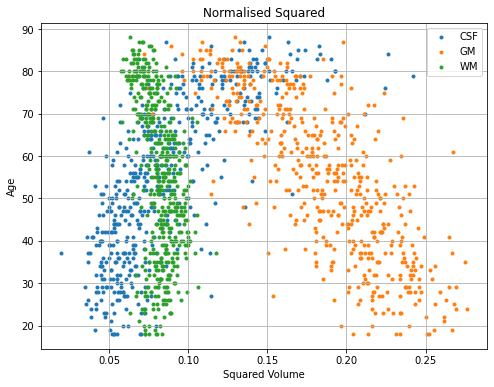

In [21]:
plt.figure(figsize=(8,6))

plt.scatter(square_X.T[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(square_X.T[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(square_X.T[2,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Normalised Squared')
plt.xlabel('Squared Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

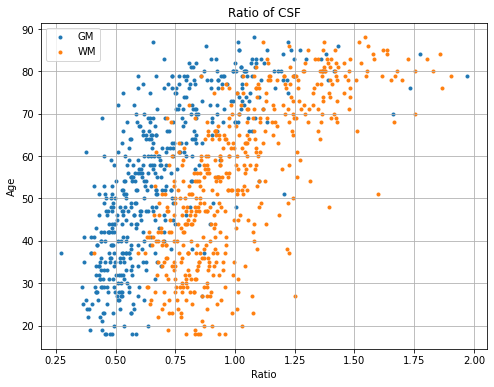

In [22]:
plt.figure(figsize=(8,6))

plt.scatter(ratio_CSF_to_GM,meta_data_reg_train['age'], marker='.')
plt.scatter(ratio_CSF_to_WM,meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Ratio of CSF')
plt.xlabel('Ratio')
plt.ylabel('Age')
plt.legend(('GM','WM'))
plt.show()

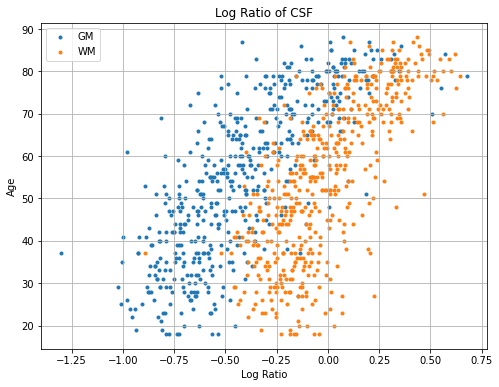

In [23]:
plt.figure(figsize=(8,6))

plt.scatter(np.log(ratio_CSF_to_GM),meta_data_reg_train['age'], marker='.')
plt.scatter(np.log(ratio_CSF_to_WM),meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Log Ratio of CSF')
plt.xlabel('Log Ratio')
plt.ylabel('Age')
plt.legend(('GM','WM'))
plt.show()

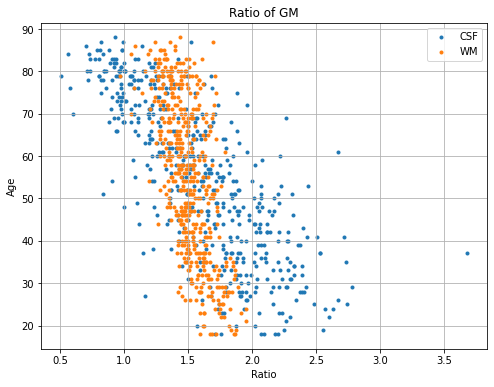

In [24]:
plt.figure(figsize=(8,6))

plt.scatter(ratio_GM_to_CSF, meta_data_reg_train['age'], marker='.')
plt.scatter(ratio_GM_to_WM, meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Ratio of GM')
plt.xlabel('Ratio')
plt.ylabel('Age')
plt.legend(('CSF','WM'))
plt.show()

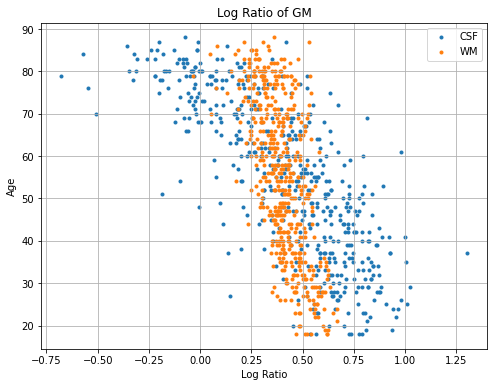

In [25]:
plt.figure(figsize=(8,6))

plt.scatter(np.log(ratio_GM_to_CSF), meta_data_reg_train['age'], marker='.')
plt.scatter(np.log(ratio_GM_to_WM), meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Log Ratio of GM')
plt.xlabel('Log Ratio')
plt.ylabel('Age')
plt.legend(('CSF','WM'))
plt.show()

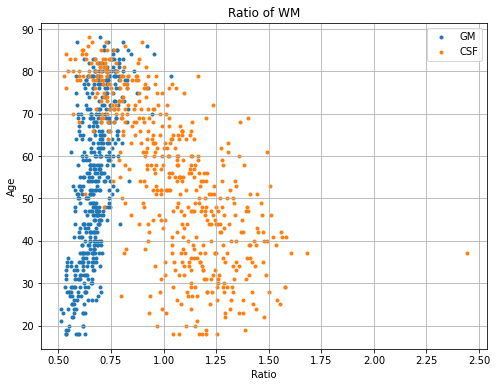

In [26]:
plt.figure(figsize=(8,6))

plt.scatter(ratio_WM_to_GM, meta_data_reg_train['age'], marker='.')
plt.scatter(ratio_WM_to_CSF, meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Ratio of WM')
plt.xlabel('Ratio')
plt.ylabel('Age')
plt.legend(('GM','CSF'))
plt.show()

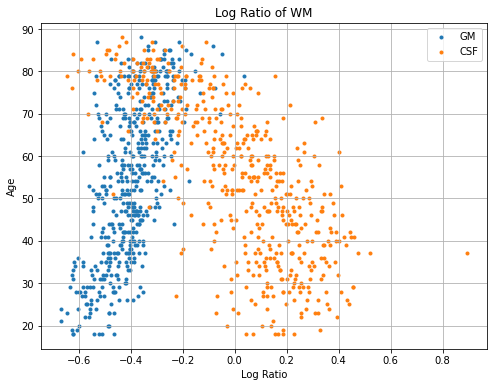

In [27]:
plt.figure(figsize=(8,6))

plt.scatter(np.log(ratio_WM_to_GM), meta_data_reg_train['age'], marker='.')
plt.scatter(np.log(ratio_WM_to_CSF), meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Log Ratio of WM')
plt.xlabel('Log Ratio')
plt.ylabel('Age')
plt.legend(('GM','CSF'))
plt.show()

Final data for age regression

In [28]:
from sklearn.feature_selection import SelectKBest, f_regression

def X_statstical_test(X, y, k):
    # preprocessing to pick the best features using an 
    # F-test to estimate the degree of linear dependency between two random variables
    selector = SelectKBest(f_regression, k=k)
    X = selector.fit_transform(X, y)
    # Get the boolean mask of selected features
    selected_mask = selector.get_support()
    return X, selected_mask

def generate_X(X, y, features_of_interest=None, statistical_test=False, k=1):
    
    if features_of_interest == None:
        return X.copy(), ["linear_X"]
    
    # Creating new features 
    linear_X = X.copy()
    square_X = X**2
    ratio_CSF_to_GM = (X[:,0]/X[:,1]).reshape(-1, 1)
    log_ratio_CSF_to_GM = np.log(ratio_CSF_to_GM)
    ratio_CSF_to_WM = (X[:,0]/X[:,2]).reshape(-1, 1)
    log_ratio_CSF_to_WM = np.log(ratio_CSF_to_WM)
    ratio_GM_to_CSF = (X[:,1]/X[:,0]).reshape(-1, 1)
    log_ratio_GM_to_CSF = np.log(ratio_GM_to_CSF)
    ratio_GM_to_WM  = (X[:,1]/X[:,2]).reshape(-1, 1)
    log_ratio_GM_to_WM = np.log(ratio_GM_to_WM)
    ratio_WM_to_GM  = (X[:,2]/X[:,1]).reshape(-1, 1)
    log_ratio_WM_to_GM = np.log(ratio_WM_to_GM)
    ratio_WM_to_CSF = (X[:,2]/X[:,0]).reshape(-1, 1)
    log_ratio_WM_to_CSF = np.log(ratio_WM_to_CSF)
    
    #add to feature list
    feature_list = {
        "linear_X":linear_X,
        "square_X":square_X,
        
        "ratio_CSF_to_GM":ratio_CSF_to_GM,
        "log_ratio_CSF_to_GM":log_ratio_CSF_to_GM,
        
        "ratio_CSF_to_WM":ratio_CSF_to_WM,
        "log_ratio_CSF_to_WM":log_ratio_CSF_to_WM,
        
        "ratio_GM_to_CSF":ratio_GM_to_CSF,
        "log_ratio_GM_to_CSF":log_ratio_GM_to_CSF,
        
        "ratio_GM_to_WM":ratio_GM_to_WM,
        "log_ratio_GM_to_WM":ratio_GM_to_WM,
        
        "ratio_WM_to_GM":log_ratio_WM_to_GM,
        "log_ratio_WM_to_GM":log_ratio_WM_to_CSF,
        
        "ratio_WM_to_CSF":ratio_WM_to_CSF,
        "log_ratio_WM_to_CSF":log_ratio_WM_to_CSF
    }
    for i, f in enumerate(features_of_interest):
        if i == 0:
            X_new = feature_list[f]
        else:
            X_new = np.concatenate((X_new, feature_list[f]), axis=1)
    
    if statistical_test:
        X_new, selected_mask = X_statstical_test(X_new, y, k)
        return X_new, selected_mask
    else:
        return X_new, np.ones(len(features_of_interest))
    

In [29]:
X = vols_normalised.T
y = meta_data_reg_train['age'].values

X_1_order_polynominal_features, X_1_order_polynominal_features_name = generate_X(X, y)
X_2_order_polynominal_features, X_2_order_polynominal_features_name = generate_X(X, y, ["linear_X", "square_X"])

X_ratio_features, X_ratio_features_name = generate_X(X, y, 
                                                     ["ratio_CSF_to_GM", "ratio_CSF_to_WM", 
                                                      "ratio_GM_to_CSF", "ratio_GM_to_WM", 
                                                      "ratio_WM_to_GM", "ratio_WM_to_CSF"])
X_log_ratio_features, X_log_ratio_features_name = generate_X(X, y, 
                                                             ["log_ratio_CSF_to_GM", "log_ratio_CSF_to_WM", 
                                                              "log_ratio_GM_to_CSF", "log_ratio_GM_to_WM", 
                                                              "log_ratio_WM_to_GM", "log_ratio_WM_to_CSF"])
X_1_hand_picked_features, X_1_hand_picked_features_names = generate_X(X, y, ["linear_X", "square_X", 
                                                                             "ratio_CSF_to_WM", "ratio_CSF_to_GM", 
                                                                             "ratio_GM_to_WM"])
X_2_hand_picked_features, X_2_hand_picked_features_names = generate_X(X, y, ["linear_X", "square_X", 
                                                                             "log_ratio_CSF_to_WM", "log_ratio_CSF_to_GM", 
                                                                             "log_ratio_GM_to_WM"]) 
X_2_order_polynominal_features_statistical_test, mask_1 = generate_X(X, y, ["linear_X", "square_X"], True, 3)
X_ratio_features_statistical_test, mask_2               = generate_X(X, y, ["ratio_CSF_to_GM", "ratio_CSF_to_WM", 
                                                                            "ratio_GM_to_CSF", "ratio_GM_to_WM", 
                                                                            "ratio_WM_to_GM", "ratio_WM_to_CSF"], 
                                                                     True, 6)
X_log_ratio_features_statistical_test, mask_3           = generate_X(X, y, ["log_ratio_CSF_to_GM", "log_ratio_CSF_to_WM", 
                                                                            "log_ratio_GM_to_CSF", "log_ratio_GM_to_WM", 
                                                                            "log_ratio_WM_to_GM", "log_ratio_WM_to_CSF"], 
                                                                     True, 6)
X_1_hand_picked_features_statistical_test, mask_4       = generate_X(X, y, ["linear_X", "square_X", 
                                                                            "ratio_CSF_to_WM", "ratio_CSF_to_GM", 
                                                                            "ratio_GM_to_WM"], True, 6)
X_2_hand_picked_features_statistical_test, mask_5       = generate_X(X, y, ["linear_X", "square_X", 
                                                                            "log_ratio_CSF_to_WM", "log_ratio_CSF_to_GM", 
                                                                            "log_ratio_GM_to_WM"], True, 6) 

X_features = {
    "X_1_order_polynominal_features":X_1_order_polynominal_features, 
    "X_2_order_polynominal_features":X_2_order_polynominal_features, 
    "X_ratio_features":X_ratio_features, 
    "X_log_ratio_features":X_log_ratio_features, 
    "X_1_hand_picked_features":X_1_hand_picked_features, 
    "X_2_hand_picked_features":X_2_hand_picked_features, 
    "X_2_order_polynominal_features_statistical_test": X_2_order_polynominal_features_statistical_test, 
    "X_ratio_features_statistical_test":X_ratio_features_statistical_test, 
    "X_log_ratio_features_statistical_test":X_log_ratio_features_statistical_test, 
    "X_1_hand_picked_features_statistical_test":X_1_hand_picked_features_statistical_test, 
    "X_2_hand_picked_features_statistical_test":X_2_hand_picked_features_statistical_test
}

X_mask = {
    "X_2_order_polynominal_features_statistical_test":mask_1,
    "X_ratio_features_statistical_test":mask_2, 
    "X_log_ratio_features_statistical_test":mask_3, 
    "X_1_hand_picked_features_statistical_test":mask_4, 
    "X_2_hand_picked_features_statistical_test":mask_5
}


### TASK A-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Remember to construct the output vectur $y$ containing the age for each of the subjects.

Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) where the dataset of 500 subjects is split into two equally sized sets $(X_1,y_1)$ and $(X_2,y_2)$ which are used for training and testing in an alternating way (so each set is used as $(X_{\text{train}},y_{\text{train}})$ and $(X_{\text{test}},y_{\text{test}})$ exactly once).

Try using at least three different regression methods, and generate a plot allows easy comparison of the performance of the three methods. Useful [error metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) to report include mean absolute error and r2 score. You might also want to plot the real vs predicted ages.

*Note:* These [scikit-learn examples](https://scikit-learn.org/stable/auto_examples/) might serve as an inspiration.

*Hint:* Be careful how you split the dataset into two folds. Take into account the data characteristics shown at the top of the notebook.

In [30]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

def test_model(model,meta_data_reg, X, y, plot_flag=False):
    
    R2_score = []
    MAE = []
    i = 1
    
    # Create a stratified 2-fold cross-validation object
    skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

    gender = meta_data_reg['gender_code'].values.reshape(-1,1)

    # Iterate over the cross-validation splits
    for train_index, test_index in skf.split(X, gender):
        # Get the training and testing data for this split
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        #Fit the model
        model.fit(X_train, y_train)
        #Predict on the held-out validation set
        y_preds = model.predict(X_test)
        #Add R2 score and MAE
        R2_score.append(r2_score(y_test, y_preds))
        MAE.append(mean_absolute_error(y_test, y_preds))
        
        if plot_flag:
            # Plot the real vs predicted ages
            fig, ax = plt.subplots()
            ax.scatter(y_test, y_preds, marker='.')
            ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
            ax.set_title(f'Cross-Validation Split {i}')
            ax.set_xlabel('Real Age')
            ax.set_ylabel('Predicted Age')
            plt.show()
            i += 1
        
    return np.mean(R2_score), np.mean(MAE) 

In [31]:
####### Regression models with different types of regularisation #######
linear_regression_model = LinearRegression()
ridge_regression_model_02 = Ridge(alpha=.2)
ridge_regression_model_05 = Ridge(alpha=.5)
ridge_regression_model_1 = Ridge(alpha=1)
ridge_regression_model_2 = Ridge(alpha=2)
lasso_regression_model_02 = Lasso(alpha=.2)
lasso_regression_model_05 = Lasso(alpha=.5)
lasso_regression_model_1 = Lasso(alpha=1)
lasso_regression_model_2 = Lasso(alpha=2)

####### Other types of regression models #######
gradient_boosting_model = GradientBoostingRegressor()
random_forest_model = RandomForestRegressor()
support_vector_model = SVR()

models = [
    linear_regression_model, 
    ridge_regression_model_02, ridge_regression_model_05, ridge_regression_model_1, ridge_regression_model_2, 
    lasso_regression_model_02, lasso_regression_model_05, lasso_regression_model_1, lasso_regression_model_2,
    gradient_boosting_model, random_forest_model,  support_vector_model
]

In [32]:
#Finding final model
min_MAE = np.inf
final_model = 0
final_features = 0

#heatmap plotting
MAE_data_all = []
R2_data_all  = []

for model in models:
    
    MAE_data = []
    R2_data  = []
    
    for key, X in X_features.items():
        R2, MAE = test_model(model, meta_data_reg_train, X, y, plot_flag=False)
        MAE_data.append(MAE)
        R2_data.append(R2)
        
        if MAE < min_MAE:
            min_MAE = MAE
            final_model = model
            final_features = key
    
    MAE_data_all.append(MAE_data)
    R2_data_all.append(R2_data)

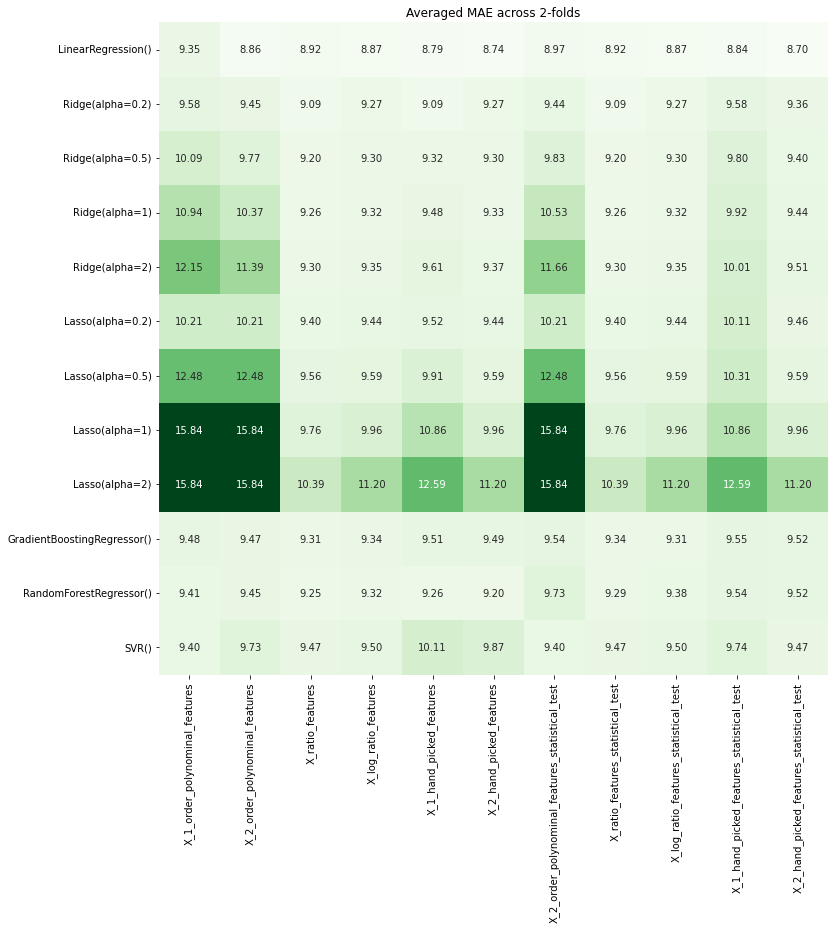

In [33]:
import seaborn as sns
plt.rcParams['figure.figsize']=(12,12)

sns.heatmap(np.array(MAE_data_all), 
            cmap="Greens", 
            xticklabels = X_features.keys(),
            yticklabels = [str(model) for model in models],
            fmt=".2f",
            annot = True,cbar=False) 

plt.title("Averaged MAE across 2-folds")
plt.show()

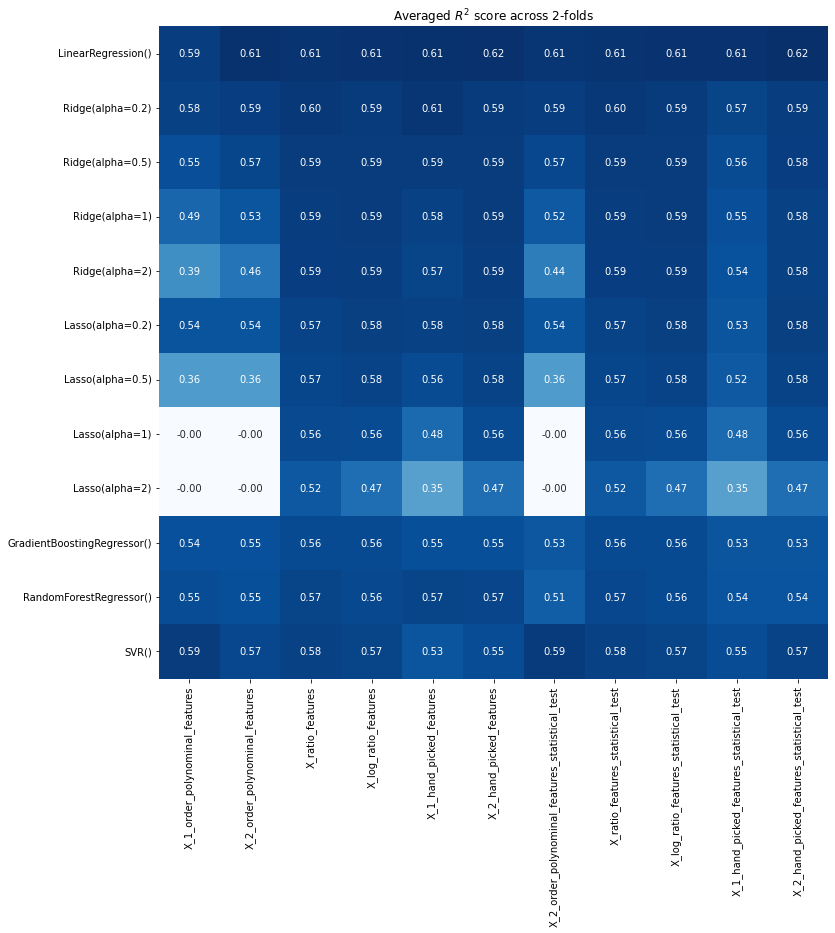

In [34]:
import seaborn as sns
plt.rcParams['figure.figsize']=(12,12)

sns.heatmap(np.array(R2_data_all), 
            xticklabels = X_features.keys(),
            yticklabels = [str(model) for model in models],
            fmt=".2f",
            annot = True,
            cmap="Blues", 
            cbar=False) 

plt.title("Averaged $R^2$ score across 2-folds")
plt.show()

Error calculation and plotting

In [35]:
def error_calculation_plotting(model, meta_data_reg_train, X, y, plot_flag=False):
    print(f"Model: {model}")
    results = test_model(model, meta_data_reg_train, X, y, plot_flag)
    print(f"Mean R2 score over the 2 folds: {results[0]}")
    print(f"Mean MAE over the 2 folds: {results[1]}")

X_2_hand_picked_features_statistical_test
Model: LinearRegression()


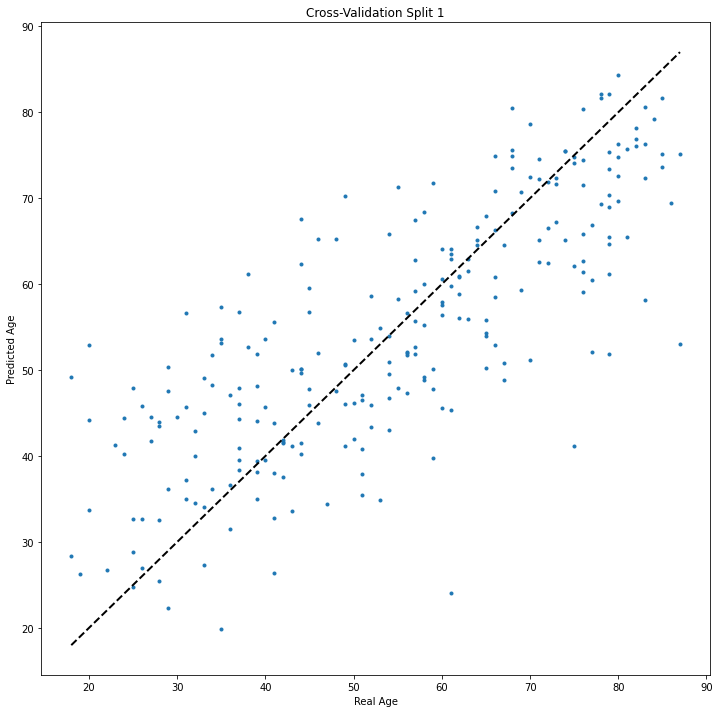

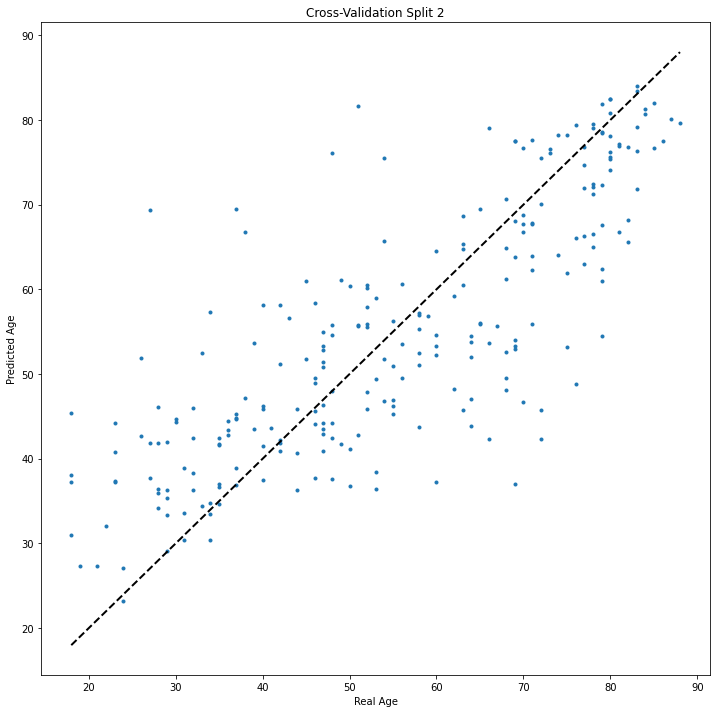

Mean R2 score over the 2 folds: 0.6210300733667329
Mean MAE over the 2 folds: 8.69550548197028


In [36]:
#Final model 
print(final_features)
error_calculation_plotting(final_model, meta_data_reg_train, X_features[final_features], y, True)

### Task A-4: Final test on hold-out data

#### Downloading data

This is only available once the final test data has been released.

In [168]:
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/mli/brainage-test-data.zip
! unzip brainage-test-data.zip

--2023-02-26 21:26:44--  https://www.doc.ic.ac.uk/~bglocker/teaching/mli/brainage-test-data.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1521 (1.5K) [application/zip]
Saving to: ‘brainage-test-data.zip.1’

brainage-test-data. 100%[===================>]   1.49K  --.-KB/s    in 0s      

2023-02-26 21:26:45 (241 MB/s) - ‘brainage-test-data.zip.1’ saved [1521/1521]

Archive:  brainage-test-data.zip
replace data/brain_age/meta/meta_data_regression_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


#### Loading and pre-processing of testing data

In [37]:
meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_regression_test.csv')
ids_seg_test = list(meta_data_reg_test['subject_id'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 100/100 [00:16<00:00,  5.96it/s]


#### Run final testing

Calculating Features: 100%|██████████| 100/100 [00:00<00:00, 170.67it/s]


Features used:['CSF' 'GM' 'CSF^2' 'GM^2' 'log_ratio_CSF_to_WM' 'log_ratio_CSF_to_GM']


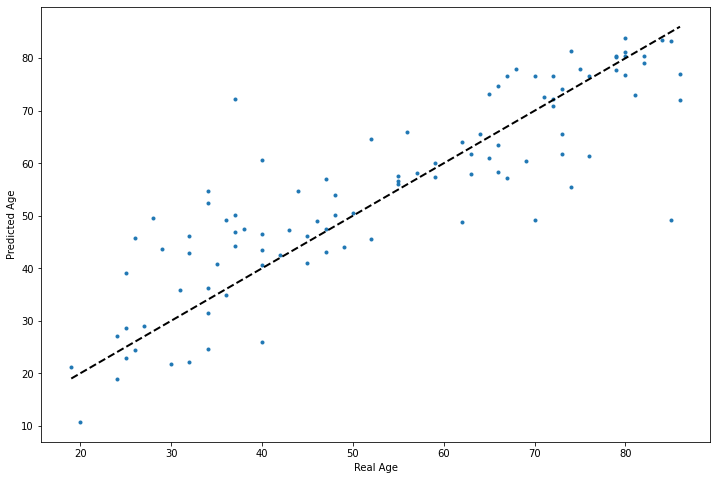

R2 score: 0.7417217697352723
MAE: 7.074684569050992


In [41]:
# Matrix per tissue class
vols = np.zeros((3,len(files_seg_seg_test)))

for idx, _ in enumerate(tqdm(range(len(files_seg_seg_test)), desc='Calculating Features')):
    
    seg_filename = files_seg_seg_test[idx]
    
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)
        seg = torch.from_numpy(sitk.GetArrayFromImage(seg)).unsqueeze(0)
        for i in range(1, 4):
            count_total = (seg == i).sum()
            vols[i-1, idx] = count_total
            
vols_normalised = np.zeros((3,len(meta_data_reg_test)))
vols_normalised = vols/vols.sum(axis=0)

# Initial data
X_test = vols_normalised.T
y_test = meta_data_reg_test['age'].values.reshape(-1,1)

# Create new features for the test set 

# Join all the features only needed from best features found in training 
X_test, _ = generate_X(X_test, y_test, ["linear_X", "square_X",
                                        "log_ratio_CSF_to_WM", "log_ratio_CSF_to_GM", "log_ratio_GM_to_WM"]) 
# Use mask to get the features found by stastical test in training 
X_test = X_test[:, X_mask[final_features]]

features_final = ["CSF","GM","WM", "CSF^2","GM^2","WM^2", "log_ratio_CSF_to_WM", "log_ratio_CSF_to_GM", "log_ratio_GM_to_WM"]
print(f"Features used:{np.array(features_final)[X_mask[final_features]]}")

# Fit the final_model to all training data
X = X_features[final_features]
model = final_model
model.fit(X, y)

# Predict on the unseen test-set
y_preds = model.predict(X_test)

# Add R2 score and MAE
R2_score = r2_score(y_test, y_preds)
MAE = mean_absolute_error(y_test, y_preds)

# Plot the real vs predicted ages
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(y_test, y_preds, marker='.')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
#ax.set_title(f'Final test on hold-out data')
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
plt.show()

print(f"R2 score: {R2_score}")
print(f"MAE: {MAE}")

## Part B: Age prediction using regression CNNs

For the second approach we will use a convolutional neural network to directly predict a subject's age.

You will need to implement a CNN model that takes an MRI scan as an input and maps it to a one-dimensional, real-valued output. A good starting point may be a LeNet-type architecture and adapt the last layers to convert the classification into a regression network. You should have all the necessary ingredients now from previous tasks and the notebooks from the lab tutorials for how to set up a CNN model in PyTorch, how to implement a suitable training and testing routine, and how to run a two-fold cross-validation on the 500 subjects similar to task A. For the final age prediction model, you should use all 500 subjects for training and you may want to use the 47 subjects that we used for training the tissue segmentation model as your validation data.

*Note:* Similar to task A, you may want to set up a pre-processing pipeline that involves intensity normalisation and resampling of the input data.

In [6]:
import os
import torch
import torch.nn as nn
import pandas as pd
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

data_dir = 'data/brain_age/'

In [7]:
class CNNRegression(nn.Module):
    
    def __init__(self):
        super(CNNRegression, self).__init__()
        self.layer_1 = nn.Sequential( 
            nn.Conv3d(1, 16, 3), 
            nn.BatchNorm3d(16), 
            nn.ReLU(inplace=True),
            nn.MaxPool3d(2)
        )
        self.layer_2 = nn.Sequential( 
            nn.Conv3d(16, 32, 3), 
            nn.BatchNorm3d(32), 
            nn.ReLU(inplace=True),
            nn.MaxPool3d(2)
        )
        self.layer_3 = nn.Sequential( 
            nn.Conv3d(32, 64, 3), 
            nn.BatchNorm3d(64), 
            nn.ReLU(inplace=True),
            nn.MaxPool3d(2)
        )
        self.layer_4 = nn.Sequential( 
            nn.Conv3d(64, 128, 3), 
            nn.BatchNorm3d(128), 
            nn.ReLU(inplace=True),
            nn.MaxPool3d(2)
        )
        self.layer_5 = nn.Sequential( 
            nn.Conv3d(128, 256, 3), 
            nn.BatchNorm3d(256), 
            nn.ReLU(inplace=True),
            nn.MaxPool3d(2)
        )
        self.fully_connected =  nn.Conv3d(256, 1, 1)

    def forward(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        x = self.layer_5(x)
        x = self.fully_connected(x)
        return x

In [8]:
cuda_dev = '0' #GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))    

Device: cuda:0
GPU: NVIDIA RTX A4000


In [9]:
def zero_mean_unit_var(image, mask):
    """Normalizes an image to zero mean and unit variance."""

    img_array = sitk.GetArrayFromImage(image)
    img_array = img_array.astype(np.float32)

    msk_array = sitk.GetArrayFromImage(mask)

    mean = np.mean(img_array[msk_array>0])
    std = np.std(img_array[msk_array>0])

    if std > 0:
        img_array = (img_array - mean) / std
        img_array[msk_array==0] = 0

    image_normalised = sitk.GetImageFromArray(img_array)
    image_normalised.CopyInformation(image)

    return image_normalised


def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)


class ImageSegmentationDataset(Dataset):
    """Dataset for image segmentation."""

    def __init__(self, file_list_img, file_list_seg, file_list_msk, file_age_list, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        self.seg_names = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            seg_path = file_list_seg[idx]
            msk_path = file_list_msk[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)

            seg = sitk.ReadImage(seg_path, sitk.sitkInt64)

            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)
            
            age = file_age_list[idx]

            #pre=processing
            img = zero_mean_unit_var(img, msk)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            seg = resample_image(seg, img_spacing, img_size, is_label=True)
            msk = resample_image(msk, img_spacing, img_size, is_label=True)

            sample = {'img': img, 'seg': seg, 'msk': msk, 'age':age}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))
            self.seg_names.append(os.path.basename(seg_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        seg = torch.from_numpy(sitk.GetArrayFromImage(sample['seg'])).unsqueeze(0)
        msk = torch.from_numpy(sitk.GetArrayFromImage(sample['msk'])).unsqueeze(0)
        age = sample['age']

        return {'img': image, 'seg': seg, 'msk': msk, 'age':age}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_seg_name(self, item):
        return self.seg_names[item]


## 2-fold cross validation

In [11]:
rnd_seed = 42 #fixed random seed

img_size = [96, 96, 96]
img_spacing = [2, 2, 2]
batch_size = 2
num_epochs = 40
learning_rate = 1e-4
criterion = nn.MSELoss()
mae_loss = nn.L1Loss()

# Training data
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_seg_train = list(meta_data_reg_train['subject_id'])
age_seg_train = list(meta_data_reg_train['age'])
files_seg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_train]
files_seg_seg_train = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_train]
files_seg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_train]

dataset_train_n_val= ImageSegmentationDataset(files_seg_img_train, files_seg_seg_train, files_seg_msk_train, age_seg_train, img_spacing, img_size)

Loading Data: 100%|██████████| 500/500 [01:08<00:00,  7.30it/s]


In [17]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import SubsetRandomSampler

# Set up Stratified Samlpling
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=rnd_seed)
gender = meta_data_reg_train['gender_code'].values.reshape(-1,1)

train_logs_epochs = []
val_logs_epochs = []
val_logs_epochs_mae = []
train_logs_epochs_mae = []

torch.cuda.empty_cache()

for f, (train_index, val_index) in enumerate(skf.split(meta_data_reg_train, gender)):
    
    # Set up
    model = CNNRegression().to(device)
    optimizer = torch.optim.RAdam(model.parameters(), lr=learning_rate, weight_decay=0.001)
    
    # Create samplers for instances
    train_sampler = SubsetRandomSampler(train_index)
    val_sampler = SubsetRandomSampler(val_index)
    
    # Create loaders, shuffle must not be specified
    dataloader_train = DataLoader(dataset_train_n_val, batch_size=batch_size, sampler=train_sampler)
    dataloader_val = DataLoader(dataset_train_n_val, batch_size=16, sampler=val_sampler)
    
    # Loss per fold
    train_loss_fold = 0
    train_loss_fold_mae = 0
    val_loss_fold = 0
    val_loss_fold_mae = 0
    
    # Loss per fold per epoch     
    loss_train_log_fold = []
    loss_train_log_fold_mae = []
    loss_val_log_fold = []
    loss_val_log_fold_mae = []
    # epoch_val_log_fold = []
    
    print(f'START TRAINING... Fold {f+1}')
    for epoch in range(1, num_epochs + 1):
        model.train()
        
        epoch_train_loss = 0
        epoch_val_loss = 0
        epoch_train_loss_mae = 0
        epoch_val_loss_mae = 0

        for batch_idx, data in enumerate(dataloader_train):
            img, age = data['img'].to(device), data['age'].to(device).float()
            optimizer.zero_grad()
            y_hat = model(img)
            loss = criterion(y_hat.resize(img.shape[0]).float(), age.float())
            loss.backward()
            optimizer.step()
            
            # Logging training loss
            epoch_train_loss += loss.item()
            epoch_train_loss_mae += mae_loss(y_hat.resize(img.shape[0]).float(), age.float()).item()
        
        # scheduler.step()
        
        epoch_train_loss_mae /= len(dataloader_val)
        epoch_train_loss /= len(dataloader_train)
        loss_train_log_fold.append(epoch_train_loss)
        loss_train_log_fold_mae.append(epoch_train_loss_mae)
        
        print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}\tMAE: {:.6}'.format(epoch, 
                                                                         loss_train_log_fold[-1], 
                                                                         loss_train_log_fold_mae[-1]))

        # Validation
        if epoch == 1 or epoch % 5 == 0:
            with torch.no_grad():
                model.eval()
                for batch_idx, data in enumerate(dataloader_val):
                    # img, msk, age = data['img'].to(device), data['msk'].to(device), data['age'].to(device)
                    img, age = data['img'].to(device), data['age'].to(device).float()
                    y_hat = model(img)
                    epoch_val_loss += criterion(y_hat.resize(img.shape[0]).float(), age.float()).item()
                    epoch_val_loss_mae += mae_loss(y_hat.resize(img.shape[0]).float(), age.float()).item()
                    
            epoch_val_loss /= len(dataloader_val)
            epoch_val_loss_mae /= len(dataloader_val)
            loss_val_log_fold.append(epoch_val_loss)
            loss_val_log_fold_mae.append(epoch_val_loss_mae)
            # epoch_val_log.append(epoch)

            print('--------------------------------------------------')
            print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f}\tMAE: {:.6}'.format(epoch, 
                                                                             loss_val_log_fold[-1], 
                                                                             loss_val_log_fold_mae[-1]))



            print('--------------------------------------------------')
    
    # Save logs per fold
    train_logs_epochs.append(loss_train_log_fold)
    val_logs_epochs.append(loss_val_log_fold)
    val_logs_epochs_mae.append(loss_val_log_fold_mae)
    train_logs_epochs_mae.append(loss_train_log_fold_mae)
    

print('\nFinished TRAINING.')

START TRAINING... Fold 1


/usr/local/lib/python3.9/dist-packages/torch/_tensor.py:586: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


+ TRAINING 	Epoch: 1 	Loss: 549.903972	MAE: 148.074
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 365.128814	MAE: 15.7962
--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 344.781959	MAE: 120.264
+ TRAINING 	Epoch: 3 	Loss: 258.741892	MAE: 105.212
+ TRAINING 	Epoch: 4 	Loss: 226.451479	MAE: 97.0684
+ TRAINING 	Epoch: 5 	Loss: 183.020034	MAE: 87.7822
--------------------------------------------------
+ VALIDATE 	Epoch: 5 	Loss: 85.852533	MAE: 7.70425
--------------------------------------------------
+ TRAINING 	Epoch: 6 	Loss: 144.851030	MAE: 75.6852
+ TRAINING 	Epoch: 7 	Loss: 132.144179	MAE: 73.8289
+ TRAINING 	Epoch: 8 	Loss: 94.715944	MAE: 62.0558
+ TRAINING 	Epoch: 9 	Loss: 80.065475	MAE: 56.4116
+ TRAINING 	Epoch: 10 	Loss: 68.662468	MAE: 52.4478
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 101.169138	MAE: 8.19362
--------------------------------------------------
+ TRAINING 	Epoch: 1

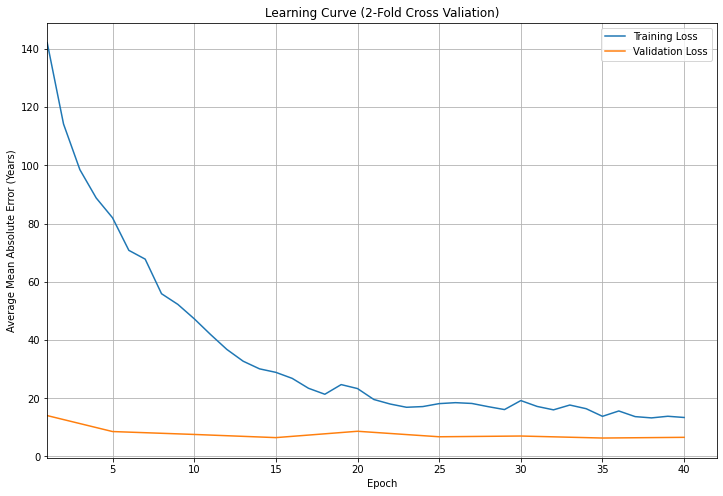

In [18]:
# Average Performance MSE
plt.figure(figsize=(12,8))
plt.plot(range(1, num_epochs+1), np.mean(train_logs_epochs_mae, axis=0), label='Training Loss')
plt.plot([i for i in range(num_epochs+1) if i == 0 or i % 5 == 0], np.mean(val_logs_epochs_mae, axis=0), label='Validation Loss')
plt.grid()
plt.xlim(1)
plt.xlabel('Epoch')
plt.ylabel('Average Mean Absolute Error (Years)')
plt.title('Learning Curve (2-Fold Cross Valiation)')
plt.legend()
plt.show()

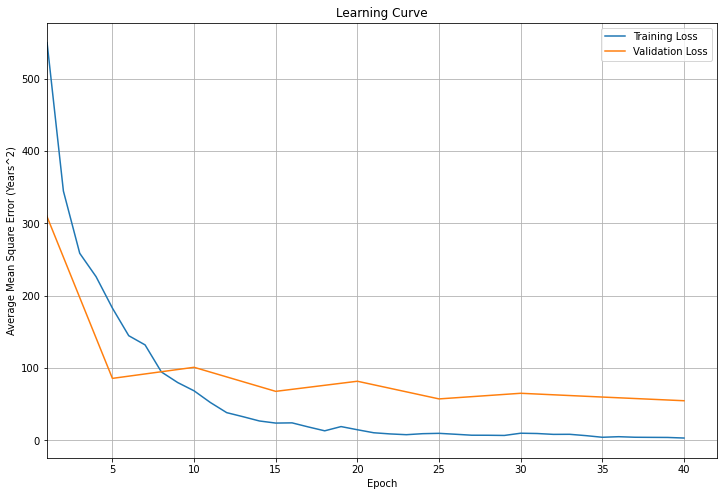

In [19]:
# Average Performance MSE
plt.figure(figsize=(12,8))
plt.plot(range(1, num_epochs+1), train_logs_epochs[0], label='Training Loss')
plt.plot([i for i in range(num_epochs+1) if i == 0 or i % 5 == 0], val_logs_epochs[0], label='Validation Loss')
plt.grid()
plt.xlim(1)
plt.xlabel('Epoch')
plt.ylabel('Average Mean Square Error (Years^2)')
plt.title('Learning Curve')
plt.legend()
plt.show()

## Training on 500 subjects

In [10]:
rnd_seed = 42 #fixed random seed

img_size = [96, 96, 96]
img_spacing = [2, 2, 2]
batch_size = 2
num_epochs = 40
learning_rate = 1e-4

# Training data
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_seg_test = list(meta_data_reg_train['subject_id'])
age_seg_test = list(meta_data_reg_train['age'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

dataset_train = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, age_seg_test, img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=1, shuffle=False)

# Validation Loader
meta_seg_val = pd.read_csv(data_dir + 'meta/meta_data_segmentation_train.csv')
ids_seg_val = list(meta_seg_val['subject_id'])
age_seg_val = list(meta_seg_val['age'])
files_seg_img_val = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_val]
files_seg_seg_val = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_val]
files_seg_msk_val = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_val]

val_dataset = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, age_seg_val, img_spacing, img_size)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


Loading Data: 100%|██████████| 47/47 [00:06<00:00,  7.31it/s]


In [11]:
def train_model(dataloader_t, dataloader_v, rnd_seed, num_epochs):
    
    torch.manual_seed(rnd_seed) #fix random seed
    
    mae_loss = nn.L1Loss()

    model = CNNRegression().to(device)
    model.train()

    optimizer = torch.optim.RAdam(model.parameters(), lr=1e-4)

    train_loss_epochs = []
    train_loss_mae_epochs = []
    val_loss_epochs = []
    val_loss_mae_epochs = []
    
    print('START TRAINING...')

    for epoch in range(1, num_epochs + 1):
        
        train_loss = 0
        train_loss_mae = 0
        val_loss = 0
        val_loss_mae = 0

        # Training
        for batch_idx, batch_samples in enumerate(dataloader_t):
            img, seg, age = batch_samples['img'].to(device), batch_samples['seg'].to(device), batch_samples['age'].to(device)
            optimizer.zero_grad()
            y_hat = model(img)
            loss = F.mse_loss(y_hat.resize(img.shape[0]).float(), age.float())
            loss.backward()
            optimizer.step()  
            
            train_loss += loss.item()
            train_loss_mae += mae_loss(y_hat.resize(img.shape[0]).float(), age.float()).item()
        
        train_loss /= len(dataloader_t)
        train_loss_mae /= len(dataloader_t)
        train_loss_epochs.append(train_loss)
        train_loss_mae_epochs.append(train_loss_mae)
        

        print('+ TRAINING \tEpoch: {} \tLoss MSE: {:.6f}'.format(epoch, train_loss))
        
        # Validation
        if epoch == 1 or epoch % 5 == 0:
            with torch.no_grad():
                model.eval()
                for batch_idx, batch_samples in enumerate(dataloader_v):
                    img, seg, age = batch_samples['img'].to(device), batch_samples['seg'].to(device), batch_samples['age'].to(device)
                    y_hat = model(img)
                    val_loss += F.mse_loss(y_hat.resize(img.shape[0]).float(), age.float()).item()
                    val_loss_mae += mae_loss(y_hat.resize(img.shape[0]).float(), age.float()).item()

            val_loss /= len(dataloader_v)
            val_loss_mae /= len(dataloader_v)
            
            val_loss_epochs.append(val_loss)
            val_loss_mae_epochs.append(val_loss_mae)
            
            print('--------------------------------------------------')
            print('+ VALIDATE \tEpoch: {} \tLoss MSE: {:.6f} \tMAE: {:.6f}'.format(epoch, val_loss, val_loss_mae))
            print('--------------------------------------------------')

    print('--------------------------------------------------')
    print('\nFinished TRAINING.')
    return model, train_loss_epochs, train_loss_mae_epochs, val_loss_epochs, val_loss_mae_epochs

In [12]:
model, train_loss_epochs, train_loss_mae_epochs, val_loss_epochs, val_loss_mae_epochs = train_model(dataloader_train, val_loader, rnd_seed, num_epochs)

START TRAINING...


/usr/local/lib/python3.9/dist-packages/torch/_tensor.py:586: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


+ TRAINING 	Epoch: 1 	Loss MSE: 302.106402
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss MSE: 201.442556 	MAE: 11.691084
--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss MSE: 152.507411
+ TRAINING 	Epoch: 3 	Loss MSE: 97.795622
+ TRAINING 	Epoch: 4 	Loss MSE: 69.990072
+ TRAINING 	Epoch: 5 	Loss MSE: 51.196988
--------------------------------------------------
+ VALIDATE 	Epoch: 5 	Loss MSE: 71.252262 	MAE: 6.733048
--------------------------------------------------
+ TRAINING 	Epoch: 6 	Loss MSE: 36.205595
+ TRAINING 	Epoch: 7 	Loss MSE: 23.652264
+ TRAINING 	Epoch: 8 	Loss MSE: 17.010329
+ TRAINING 	Epoch: 9 	Loss MSE: 17.307298
+ TRAINING 	Epoch: 10 	Loss MSE: 24.884695
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss MSE: 65.613534 	MAE: 6.616030
--------------------------------------------------
+ TRAINING 	Epoch: 11 	Loss MSE: 47.231810
+ TRAINING 	Epoch: 12 	Loss MSE: 49.488172
+ TRAINING 

In [16]:
out_dir = 'data/brain_age/'
model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.save(model.state_dict(), os.path.join(model_dir, 'model_part_b.pt'))

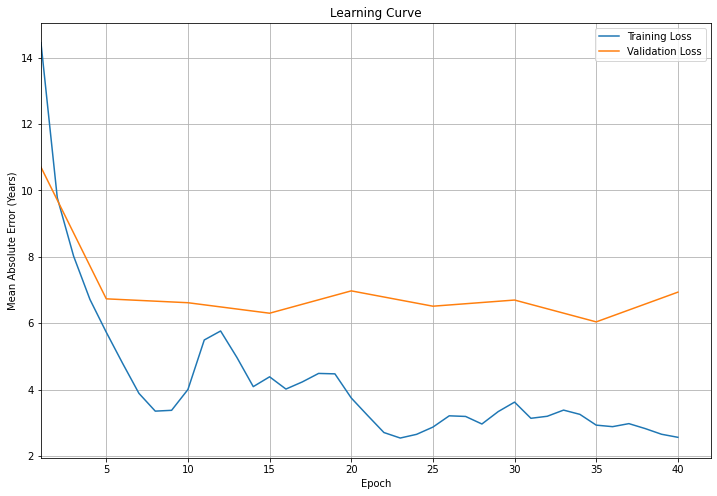

In [17]:
plt.figure(figsize=(12,8))
plt.plot(range(1, num_epochs+1), train_loss_mae_epochs, label='Training Loss')
plt.plot([i for i in range(num_epochs+1) if i == 0 or i % 5 == 0], [i for i in val_loss_mae_epochs], label='Validation Loss')
plt.grid()
plt.xlim(1)
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (Years)')
plt.title('Learning Curve')
plt.legend()
plt.show()

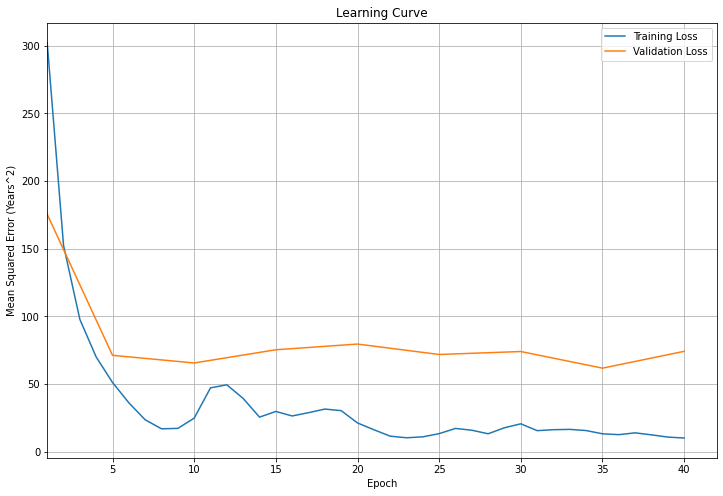

In [18]:
plt.figure(figsize=(12,8))
plt.plot(range(1, num_epochs+1), train_loss_epochs, label='Training Loss')
plt.plot([i for i in range(num_epochs+1) if i == 0 or i % 5 == 0], [i for i in val_loss_epochs], label='Validation Loss')
plt.grid()
plt.xlim(1)
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (Years^2)')
plt.title('Learning Curve')
plt.legend()
plt.show()

## Testing

In [22]:
meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_regression_test.csv')
ids_seg_test = list(meta_data_reg_test['subject_id'])
age_seg_test = list(meta_data_reg_test['age'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, age_seg_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 100/100 [00:10<00:00,  9.46it/s]


/usr/local/lib/python3.9/dist-packages/torch/_tensor.py:586: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


<class 'numpy.ndarray'>


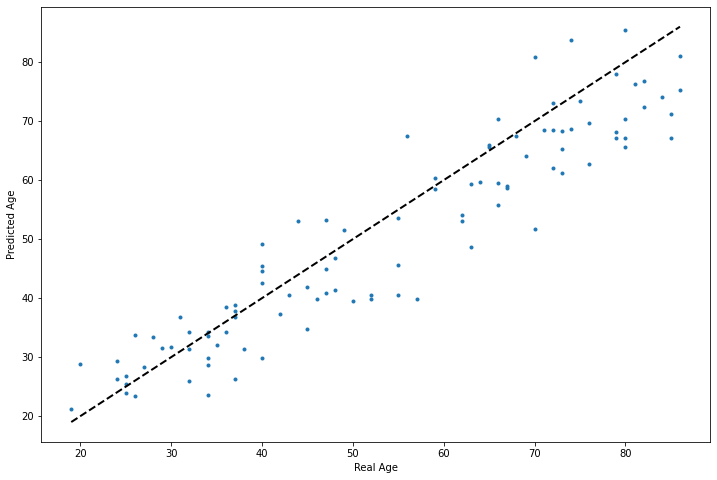

R2 score: 0.8446643263613974
MAE: 6.2111349868774415


In [23]:
from sklearn.metrics import mean_absolute_error, r2_score

model.eval()

y_test = np.array(age_seg_test)
y_preds = np.zeros(100)
# Training
for batch_idx, batch_samples in enumerate(dataloader_test):

    img, seg, age = batch_samples['img'].to(device), batch_samples['seg'].to(device), batch_samples['age'].to(device)
    y_hat = model(img)
    y_preds[batch_idx] = y_hat.resize(1).float().cpu().detach().numpy()

print(type(y_test))
# Add R2 score and MAE
R2_score = r2_score(y_test, y_preds)
MAE = mean_absolute_error(y_test, y_preds)

# Plot the real vs predicted ages
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(y_test, y_preds, marker='.')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
#ax.set_title(f'Final test on hold-out data')
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
plt.show()

print(f"R2 score: {R2_score}")
print(f"MAE: {MAE}")